In [9]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.integrate import quad
from scipy.special import erfinv
from scipy.special import erf
from scipy.stats import skew, kurtosis
from scipy.stats import norm
from scipy.stats import chi2
from matplotlib import rc
from scipy.special import gamma
from scipy.stats import poisson
from scipy.stats import chisquare
from scipy.optimize import root_scalar
from scipy.optimize import minimize
import pandas as pd
from scipy.stats import ks_2samp, ksone

In [121]:
m0 = 1.66e-27
K_40_mass = 40*m0 #kg
kb = 1.3806e-23 #J/K
T = 30 #K

beta = 1/(kb*T)

A = np.sqrt(beta/math.pi)


rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

# Task 1: Basic Statistical Properties

### a)


A function is considered a probability densiy function if it satisfies these two condition: 

- Non-negativity, meaning f(Ew) >= 0 for all Ew >=0
- Normalization, where the integral of the PDF over its domain must be equal to 1

/var/folders/0y/496_zl5905jfg059dd524bvm0000gn/T/ipykernel_78496/2849937601.py:10: RuntimeWarning: divide by zero encountered in divide
  return A * np.exp(-beta * eps) / np.sqrt(eps)


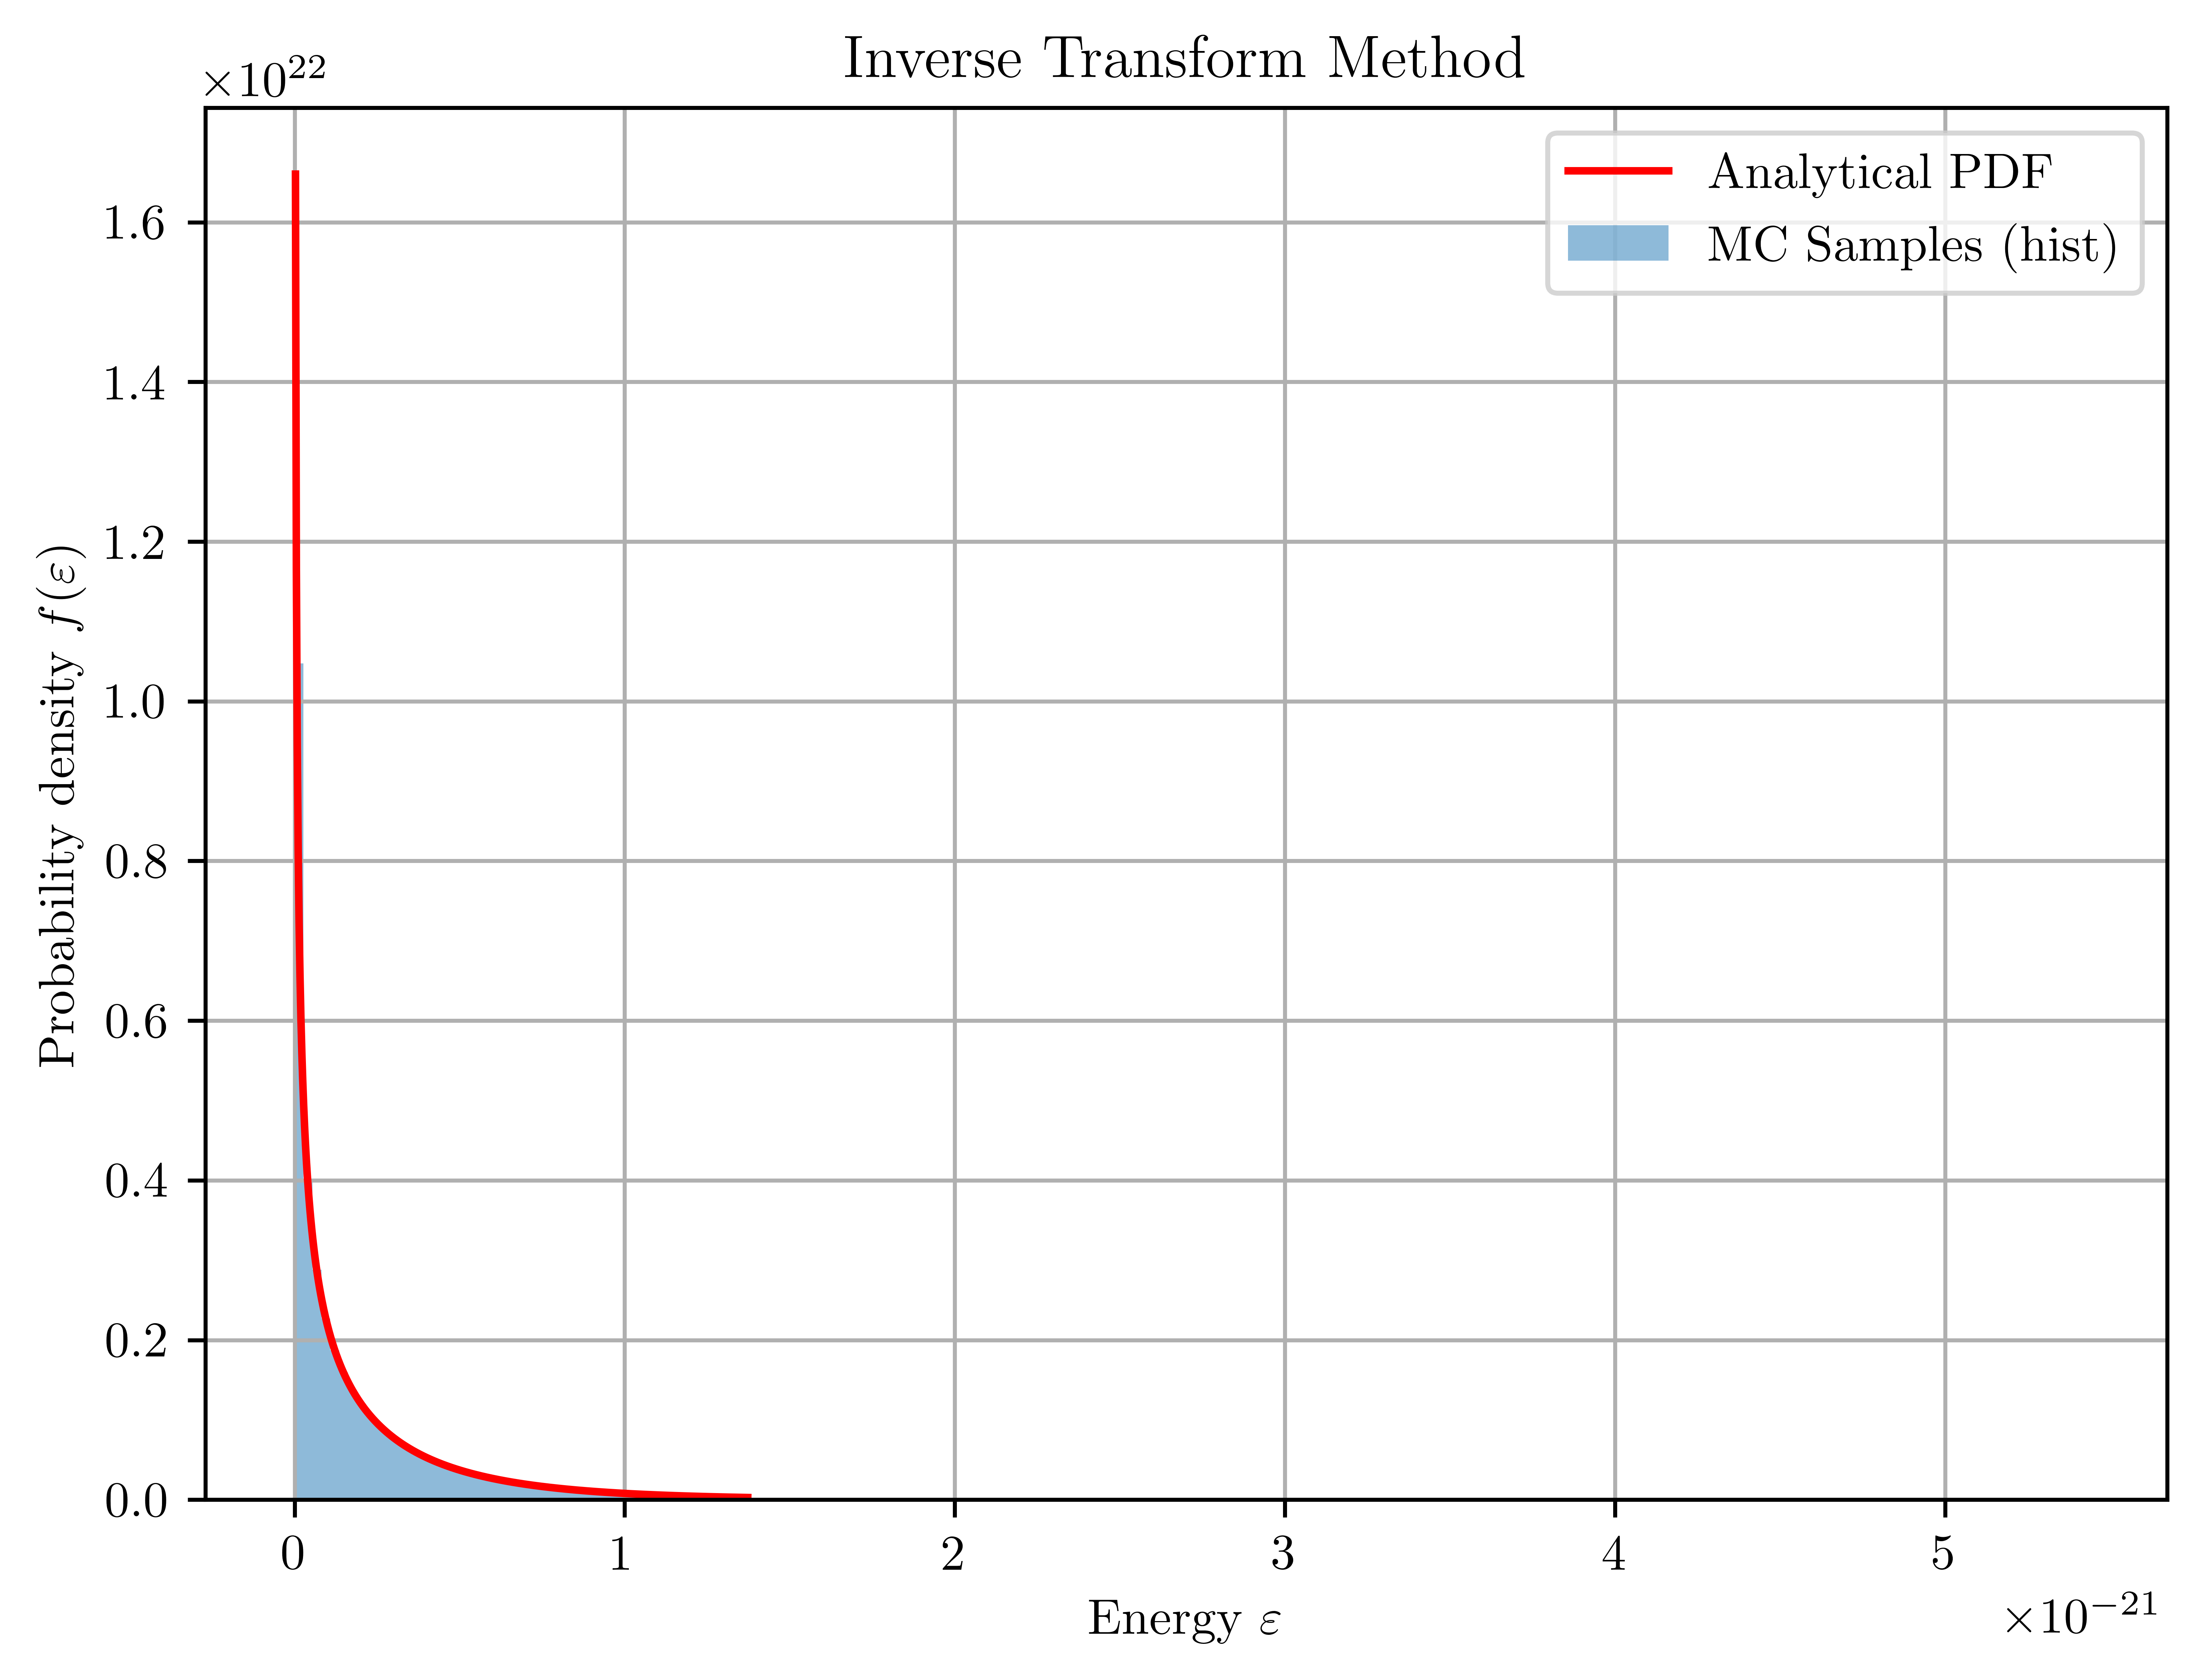

In [3]:


def sample_energy_inverse_transform(N, beta):
    """Generate N samples using the inverse transform method."""
    U = np.random.rand(N)
    return (erfinv(U)**2) / beta

def pdf(eps, beta):
    """Analytical PDF for f(ε) = sqrt(beta/pi) * exp(-beta ε) / sqrt(ε)."""
    
    A = np.sqrt(beta / math.pi)
    return A * np.exp(-beta * eps) / np.sqrt(eps)

# --- Main script ---
N = 1000000  # e.g. 1e5 samples

# 1) Generate samples
energy_samples = sample_energy_inverse_transform(N, beta)

# 2) Make a histogram of the samples
bins = 200
hist, bin_edges = np.histogram(energy_samples, bins=bins, density=True)
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])

# 3) Plot the histogram versus the analytical PDF
plt.figure(figsize=(7,5), dpi=1000)
plt.bar(bin_centers, hist, width=(bin_edges[1]-bin_edges[0]),
        alpha=0.5, label='MC Samples (hist)')

# Evaluate the PDF on a smooth grid
eps_grid = np.linspace(0, np.percentile(energy_samples, 99.0), 500)
pdf_values = pdf(eps_grid, beta)
plt.plot(eps_grid, pdf_values, 'r-', label='Analytical PDF')

plt.xlabel(r'Energy $\varepsilon$')
plt.ylabel(r'Probability density $f(\varepsilon)$')
plt.title('Inverse Transform Method')

plt.legend()
plt.grid(True)
plt.show()

In [57]:
mean_values = np.mean(sample_energy_inverse_transform(N, beta))

analytical_expectation_value = 0.5 * kb * T


print(f"Sample Mean <Ew>: {mean_values:.5e} J")
print(f"Analytical Expectation Value: {analytical_expectation_value:.5e} J")


print(f"Relative Error: {abs(mean_values - analytical_expectation_value) / analytical_expectation_value:.5e}")

Sample Mean <Ew>: 2.06863e-22 J
Analytical Expectation Value: 2.07090e-22 J
Relative Error: 1.09527e-03


### Reasons why we have managed to improve the code

1. Numerical Stability

The target PDF  f(\epsilon)  involves terms that can become singular or very small near  \epsilon = 0 . To avoid numerical instability:
	•	Small or zero values in the proposal PDF  g(\epsilon)  are replaced with a minimum threshold (1 \times 10^{-10}).
	•	The sampling grid starts at  \epsilon = 1 \times 10^{-10}  instead of zero to prevent division by zero and undefined behavior.

2. Dynamic Calculation of M

The rejection sampling method requires a scaling factor M to ensure the proposal PDF  g(\epsilon)  envelopes the target PDF  f(\epsilon) . Using a static M may:
	•	Overestimate M, leading to inefficiency with high rejection rates.
	•	Underestimate M, causing invalid results.

Dynamically calculating M from the ratio of  f(\epsilon) / g(\epsilon)  ensures:
	•	Optimal efficiency by reducing rejection rates.
	•	Accuracy by safely enveloping the target PDF.

3. Parameter Tuning

The parameter \lambda in the exponential proposal distribution  g(\epsilon) = \lambda e^{-\lambda \epsilon}  directly impacts the shape of the proposal PDF:
	•	A poorly chosen \lambda can lead to a large M, increasing computational cost.
	•	Optimizing \lambda = 1.5 \times \beta aligns g(\epsilon) better with f(\epsilon), reducing the rejection rate.

4. Progress Tracking

For large Monte Carlo simulations, adding progress tracking allows:
	•	Monitoring the number of proposals and accepted samples.
	•	Evaluating the acceptance rate, which is crucial for debugging and optimizing performance.

5. Saving the Plot

Saving the histogram and analytical PDF comparison ensures:
	•	Results can be revisited for verification or analysis.
	•	Avoids the need to regenerate plots after long computations.

These recommendations collectively enhance the accuracy, efficiency, and reliability of the Monte Carlo rejection sampling process.

Calculated M: 4.4917998085341875
Sampling Efficiency: 21.16%


/var/folders/0y/496_zl5905jfg059dd524bvm0000gn/T/ipykernel_14038/2958858612.py:4: RuntimeWarning: divide by zero encountered in divide
  return A * np.exp(-beta * eps) / np.sqrt(eps)


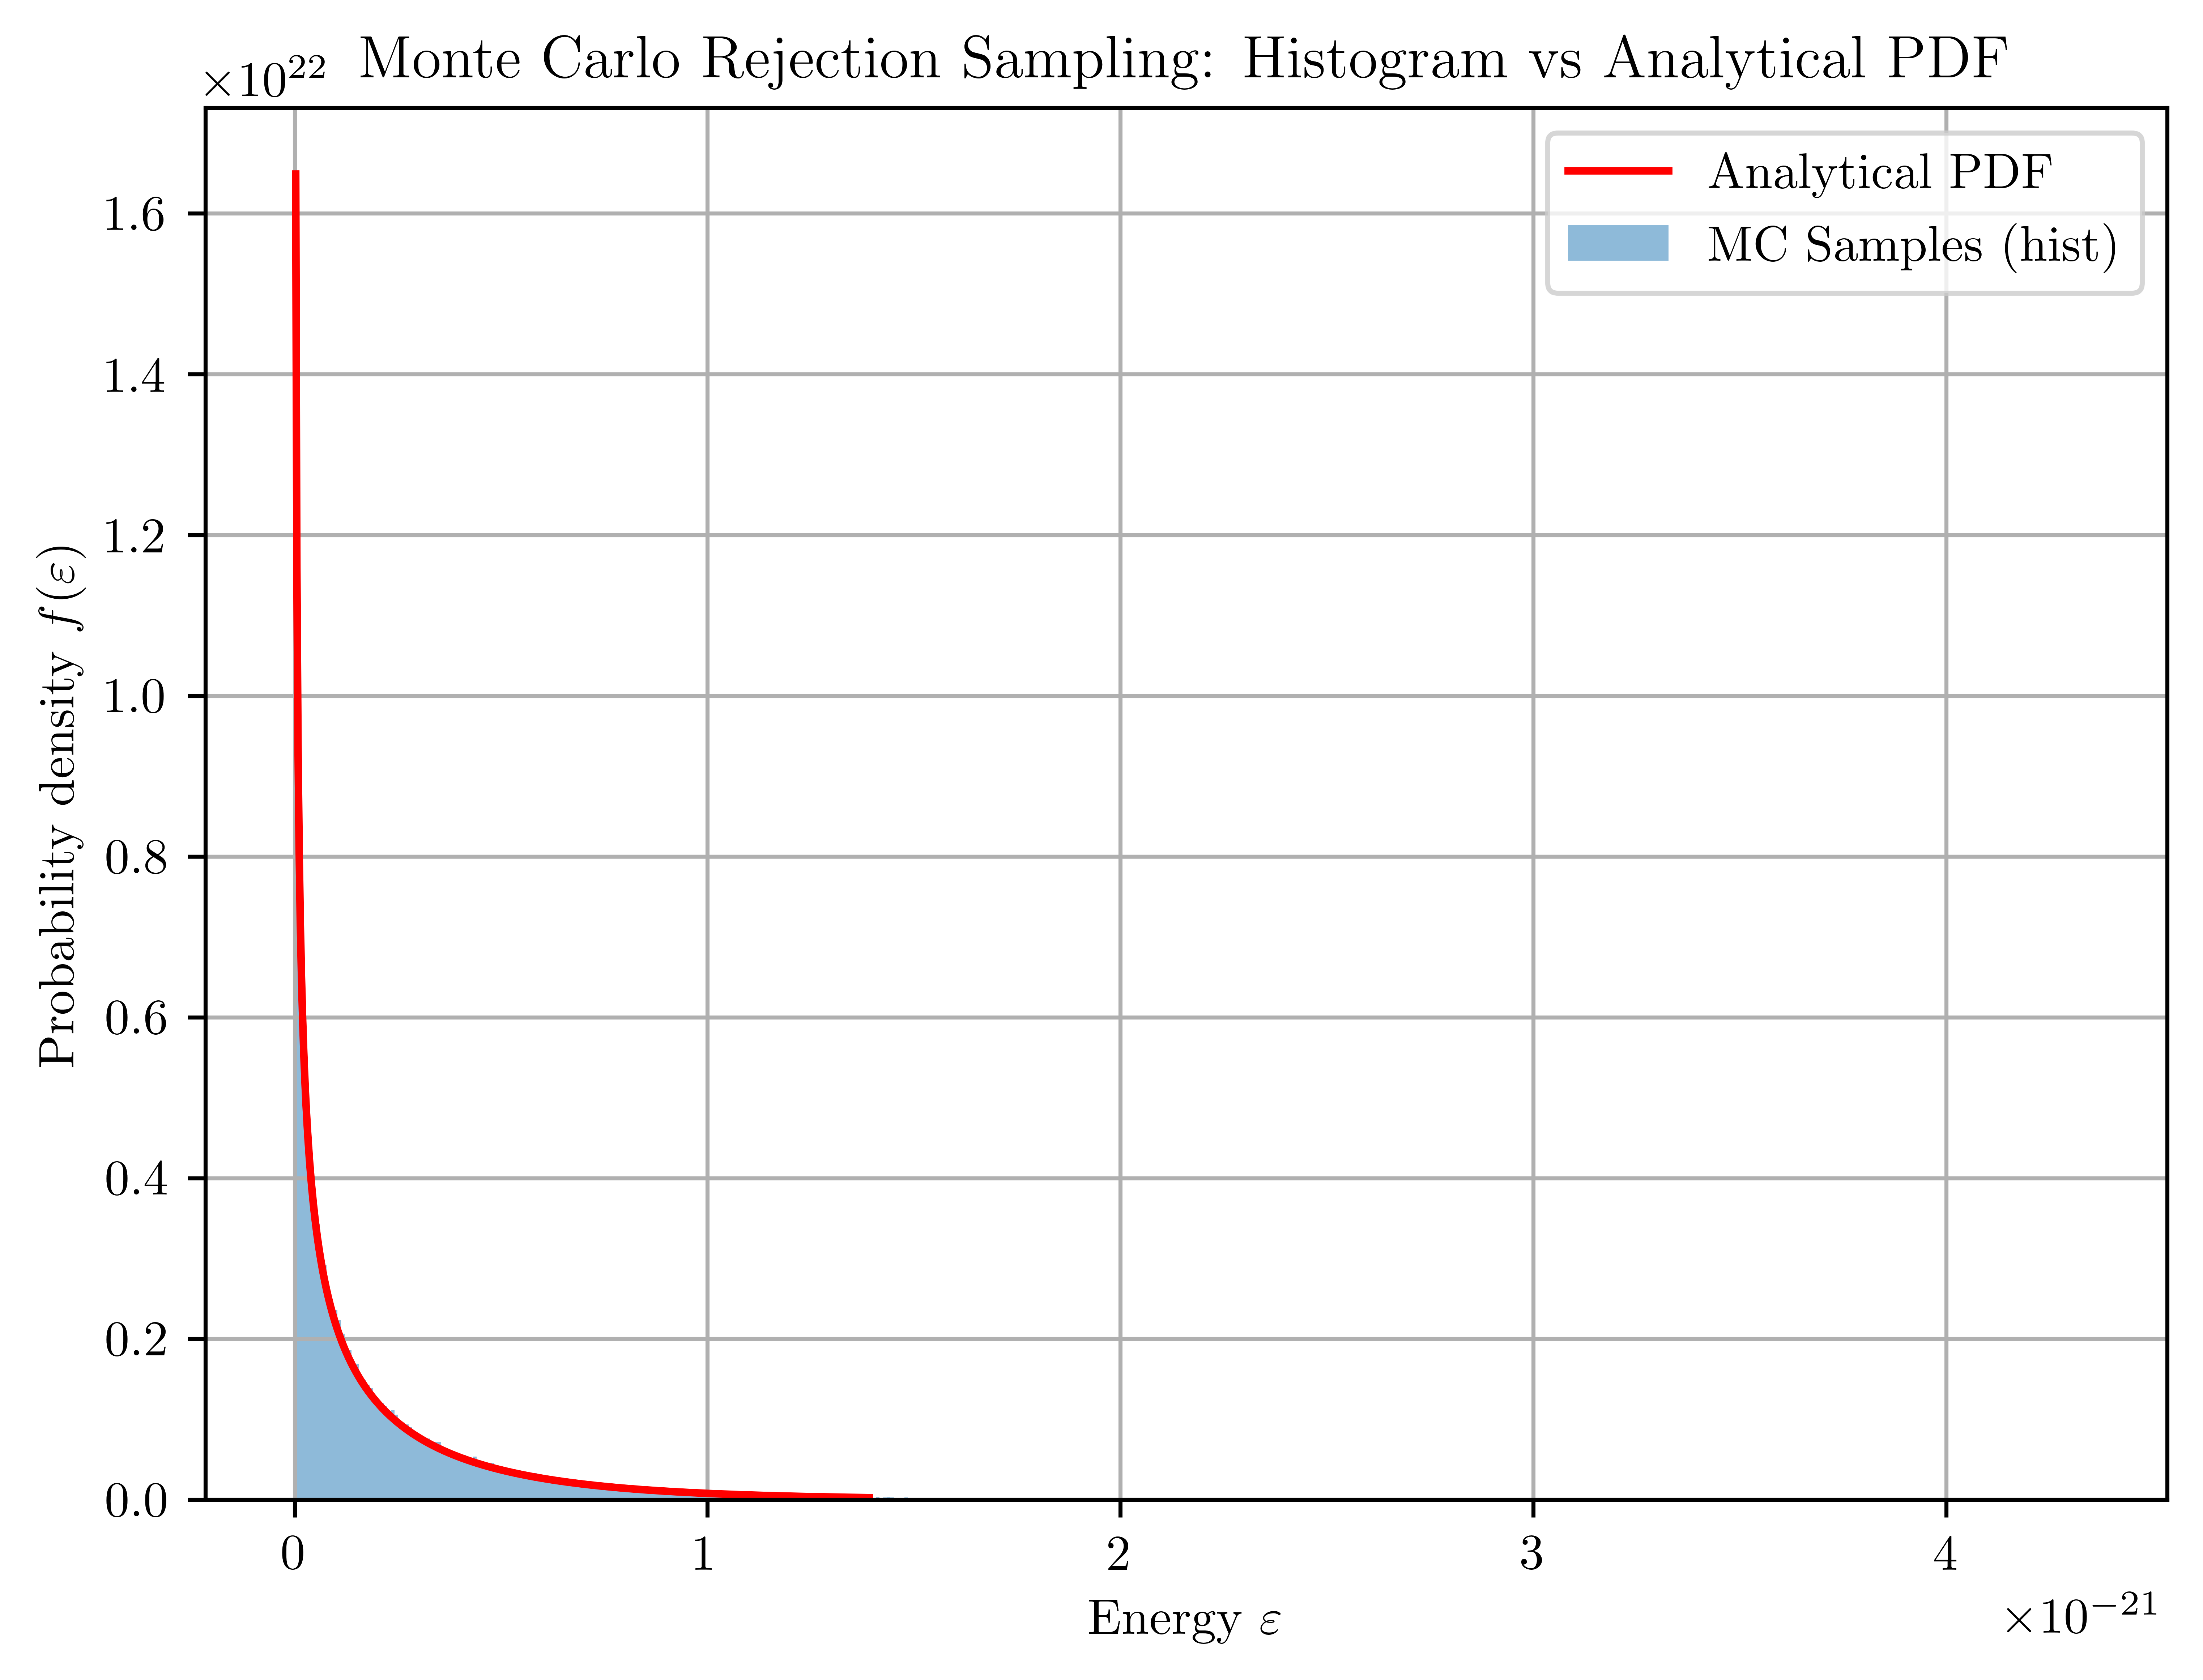

In [66]:
def target_pdf(eps, beta):
    """Target PDF: f(ε) = sqrt(beta/pi) * exp(-beta ε) / sqrt(ε)."""
    A = np.sqrt(beta / math.pi)
    return A * np.exp(-beta * eps) / np.sqrt(eps)

def proposal_pdf(eps, lam):
    """Proposal PDF: g(ε) = λ exp(-λ ε)."""
    return lam * np.exp(-lam * eps)

def sample_from_proposal(lam, size):
    """Generate samples from exponential distribution g(ε)."""
    return np.random.exponential(1 / lam, size)

def rejection_sampling(N, beta, lam):
    """Rejection sampling using target f(ε) and proposal g(ε) with dynamic M."""
    # --- Dynamic calculation of M ---
    eps_grid = np.linspace(1e-10, 10 / lam, 1000)  # Avoid starting at 0
    target_vals = target_pdf(eps_grid, beta)
    proposal_vals = np.maximum(proposal_pdf(eps_grid, lam), 1e-10)  # Ensure no division by zero
    
    ratio = target_vals / proposal_vals
    if np.any(np.isnan(ratio)) or np.any(np.isinf(ratio)):
        raise ValueError("Ratio contains NaN or infinite values.")

    M = 1.1 * np.max(ratio)  # Add a safety margin to avoid boundary issues
    print(f"Calculated M: {M}")
    
    # --- Rejection sampling ---
    samples = []
    total_proposals = 0
    while len(samples) < N:
        eps_proposed = sample_from_proposal(lam, 1)[0]
        total_proposals += 1
        
        accept_prob = target_pdf(eps_proposed, beta) / (M * proposal_pdf(eps_proposed, lam))
        if np.random.rand() < accept_prob:
            samples.append(eps_proposed)
        
        # # Optional progress tracking
        # if total_proposals % 10000 == 0:
        #     print(f"Proposals: {total_proposals}, Accepted: {len(samples)}, Acceptance Rate: {len(samples) / total_proposals:.2%}")
    
    #print(f"Generated {len(samples)} samples after {total_proposals} proposals.")
    
    efficiency = len(samples) / total_proposals
    print(f"Sampling Efficiency: {efficiency:.2%}")
    return np.array(samples)

# --- Parameters ---
kb = 1.3806e-23  # Boltzmann constant (J/K)
T = 30  # Temperature (K)
beta = 1 / (kb * T)  # Inverse temperature
lam = beta * 1.5  # Adjusted lambda to improve efficiency
N = 100000  # Number of Monte Carlo samples

# --- Run Rejection Sampling ---
samples = rejection_sampling(N, beta, lam)

# --- Plot Results ---
bins = 500
hist, bin_edges = np.histogram(samples, bins=bins, density=True)
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])

# Analytical PDF
eps_grid = np.linspace(0, np.percentile(samples, 99.0), 500)
pdf_values = target_pdf(eps_grid, beta)

plt.figure(figsize=(7, 5), dpi=1000)
plt.bar(bin_centers, hist, width=(bin_edges[1] - bin_edges[0]), alpha=0.5, label="MC Samples (hist)")
plt.plot(eps_grid, pdf_values, 'r-', label="Analytical PDF")
plt.xlabel(r"Energy $\varepsilon$")
plt.ylabel(r"Probability density $f(\varepsilon)$")
plt.title("Monte Carlo Rejection Sampling: Histogram vs Analytical PDF")
plt.legend()
plt.grid(True)
plt.savefig("monte_carlo_sampling.png")  # Save the plot
plt.show()

In [67]:

mean_samples = np.mean(rejection_sampling(N, beta, lam))
analytical_expectation_value = 0.5 * kb * T


    
    
print(f"Sample Mean <Ew>: {mean_samples:.5e} J")
print(f"Analytical Expectation Value: {analytical_expectation_value:.5e} J")


print(f"Relative Error: {abs(mean_samples - analytical_expectation_value) / analytical_expectation_value:.5e}")

Calculated M: 4.4917998085341875
Sampling Efficiency: 21.26%
Sample Mean <Ew>: 2.17177e-22 J
Analytical Expectation Value: 2.07090e-22 J
Relative Error: 4.87082e-02


In [71]:
N = 1000000
beta = 1/(kb*T)
lam = beta * 1.5

def compute_statistics(samples):
    """Compute mean, variance, skewness, and kurtosis of the energy samples."""
    mean = np.mean(samples)  
    variance = np.var(samples)
    skewness = skew(samples)  
    kurt = kurtosis(samples, fisher=False)  
    
    return mean, variance, skewness, kurt

mean_Inverse, variance_Inverse, skewness_Inverse, kurt_Inverse = compute_statistics(sample_energy_inverse_transform(N, beta))

mean_Neumann, variance_Neumann, skewness_Neumann, kurt_Neumann = compute_statistics(rejection_sampling(N, beta, lam))


print(((kb*T)**2)/2)

print("For the Inverse Transform Method:")
print(f"Mean (⟨E⟩): {mean_Inverse:.5e} J")
print(f"Variance: {variance_Inverse:.5e} J^2")
print(f"Skewness: {skewness_Inverse:.5f}")
print(f"Kurtosis: {kurt_Inverse:.5f}\n\n")


print("For the Von Neumann method:")
print(f"Mean (⟨E⟩): {mean_Neumann:.5e} J")
print(f"Variance: {variance_Neumann:.5e} J^2")
print(f"Skewness: {skewness_Neumann:.5f}")
print(f"Kurtosis: {kurt_Neumann:.5f}")

Calculated M: 4.4917998085341875
Sampling Efficiency: 21.22%
8.577253619999998e-44
For the Inverse Transform Method:
Mean (⟨E⟩): 2.07226e-22 J
Variance: 8.59217e-44 J^2
Skewness: 2.82694
Kurtosis: 14.92855


For the Von Neumann method:
Mean (⟨E⟩): 2.17222e-22 J
Variance: 8.70786e-44 J^2
Skewness: 2.72427
Kurtosis: 13.78430


# Task 2 - Convergence

### a) Law of Large Numbers 

Take Nexp = 1 and show the law of large numbers based on the data points you generated.

2.0708999999999997e-22


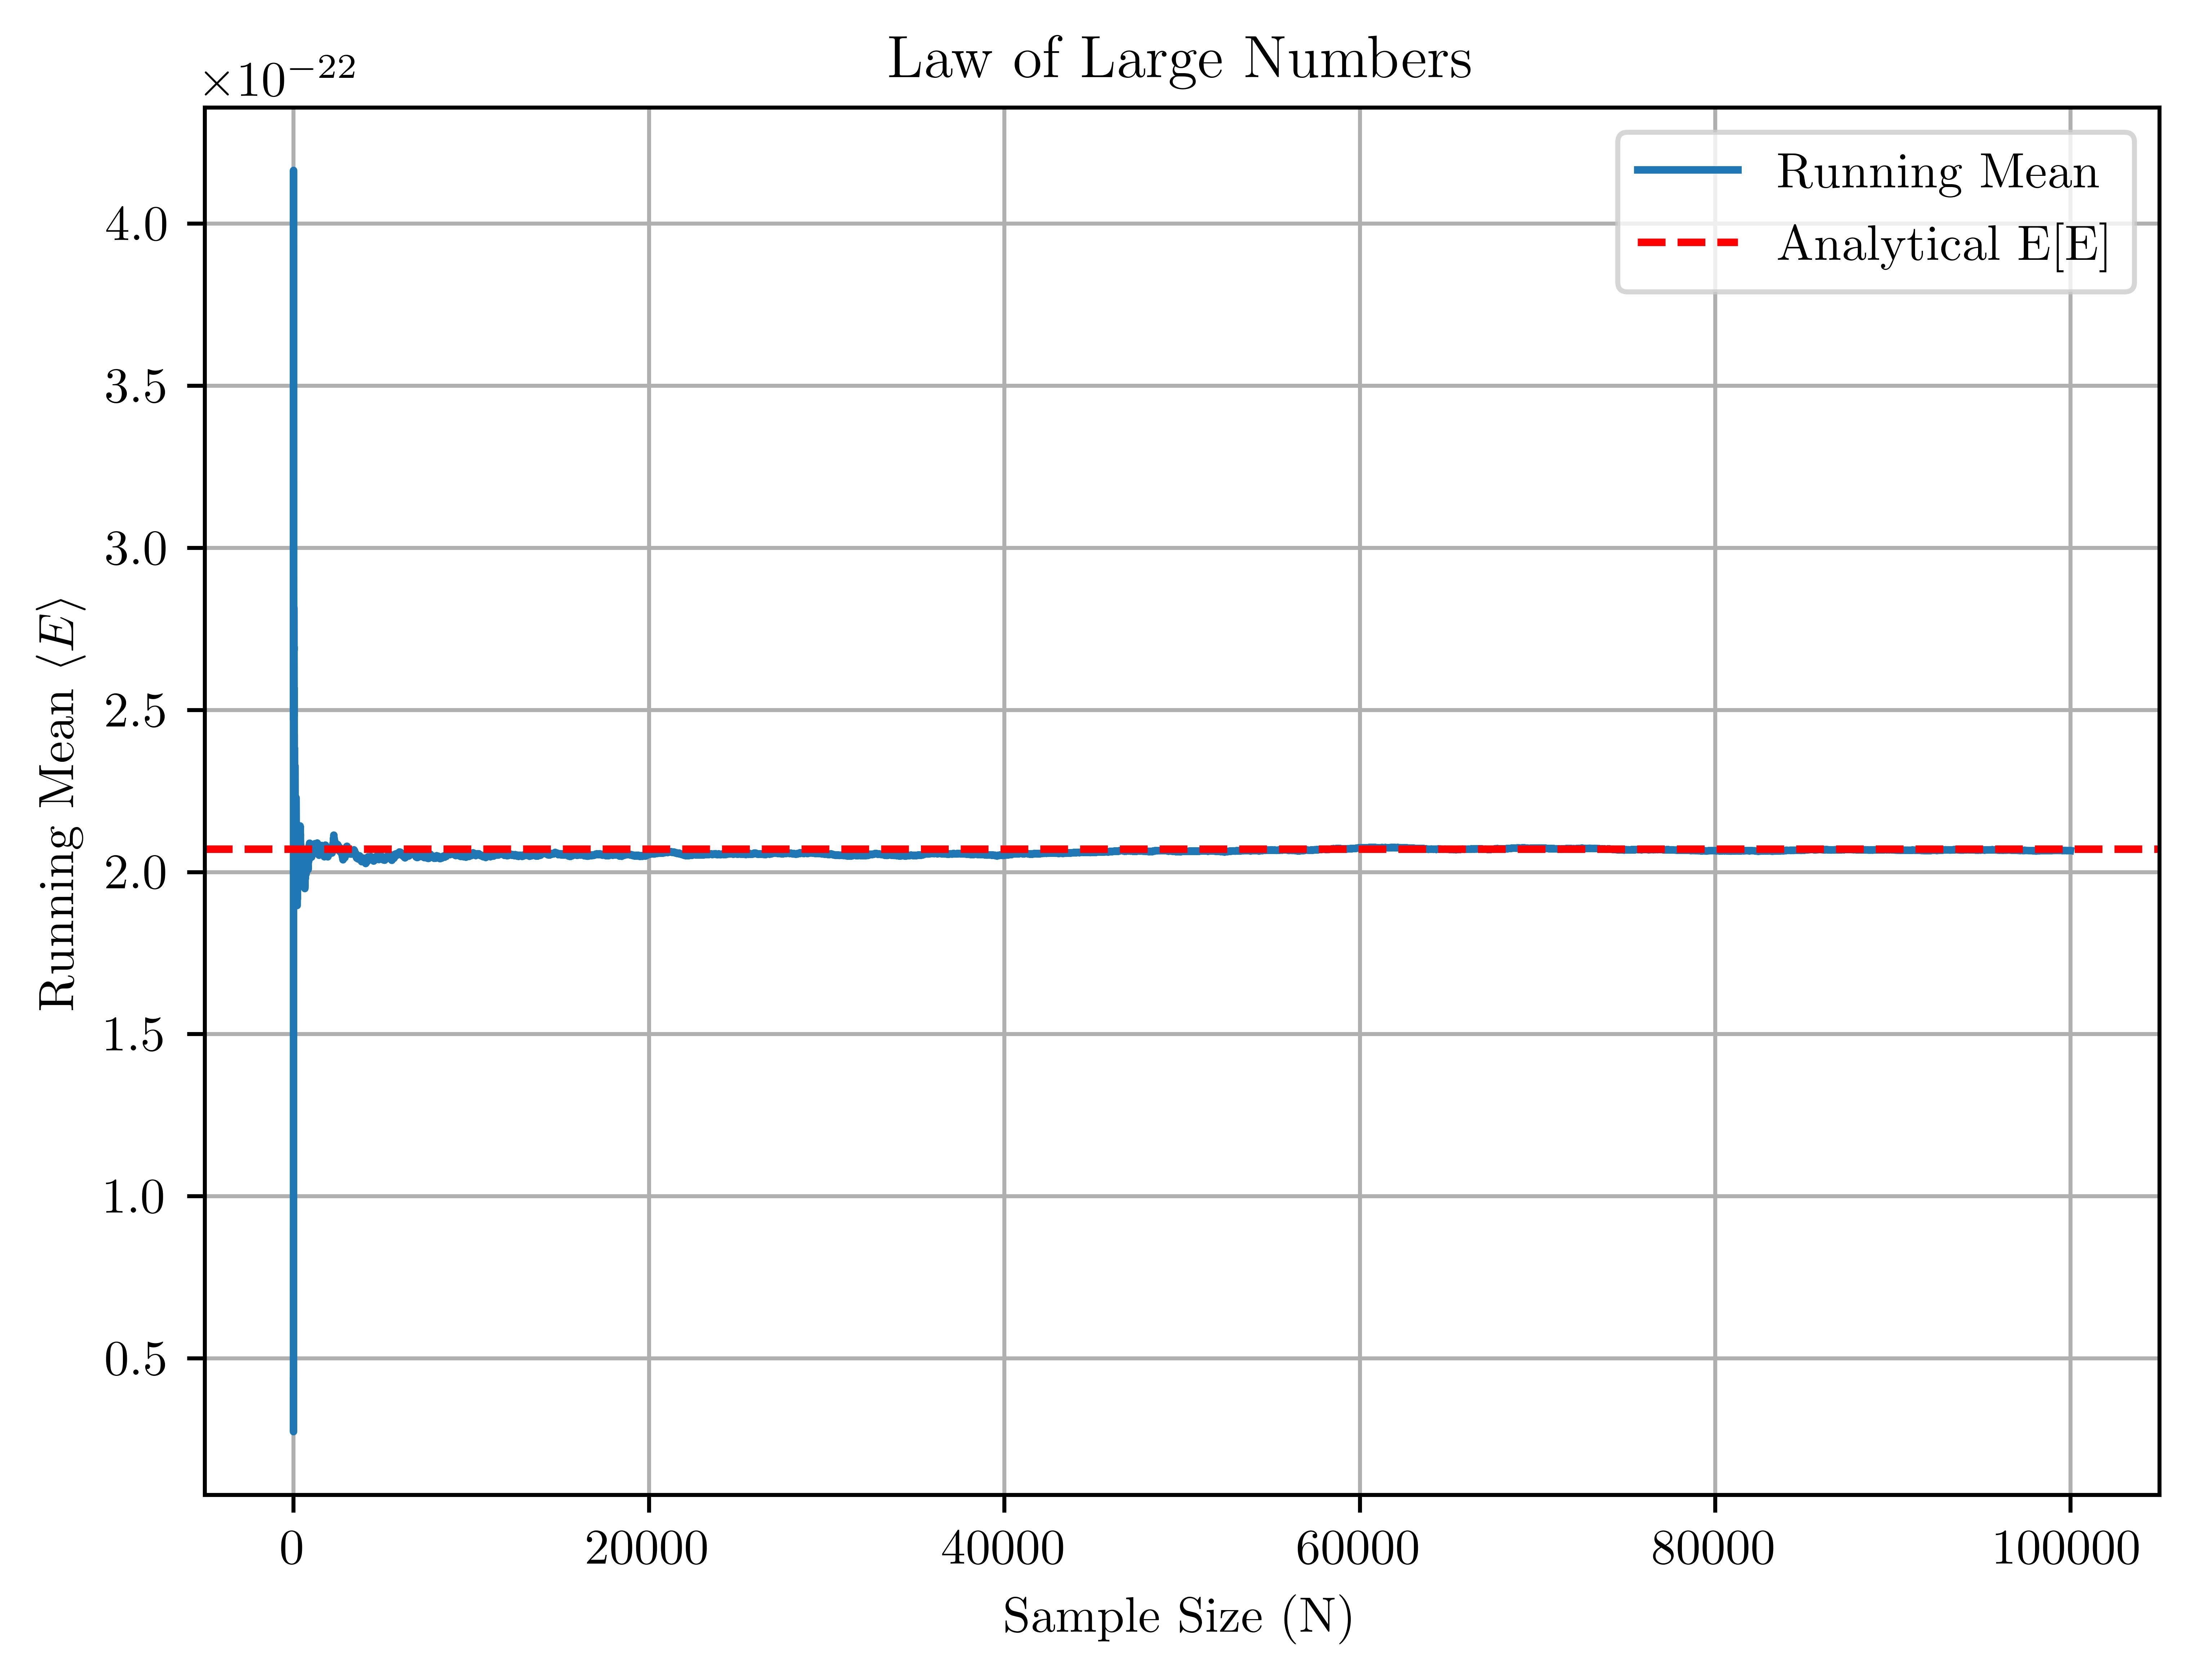

In [77]:
def compute_expectation_and_variance(kb, T):
    """Analytical expectation value and variance."""
    expectation = 0.5 * kb * T  
    variance = ((kb*T)**2)/2  
    return expectation, variance



N=100000

expectation, variance = compute_expectation_and_variance(kb, T)

lam = beta * 1.5

# --- a) Law of Large Numbers ---
# Generate samples
# samples = rejection_sampling(N, beta, lam)
samples = sample_energy_inverse_transform(N, beta)

# Compute running mean
running_mean = np.cumsum(samples) / np.arange(1, N + 1)
print(expectation)



# Plot running mean vs. sample size
plt.figure(figsize=(7, 5), dpi=1000)
plt.plot(np.arange(1, N + 1), running_mean, label="Running Mean")
plt.axhline(expectation, color="r", linestyle="--", label="Analytical E[E]")
plt.xlabel("Sample Size (N)")
plt.ylabel(r"Running Mean $\langle E \rangle$")
plt.title("Law of Large Numbers")
plt.legend()
plt.grid(True)
plt.show()

### b) Central Limit Theorem

Take Nexp >> 1 and show the validity of the central limit theorem for <E>.

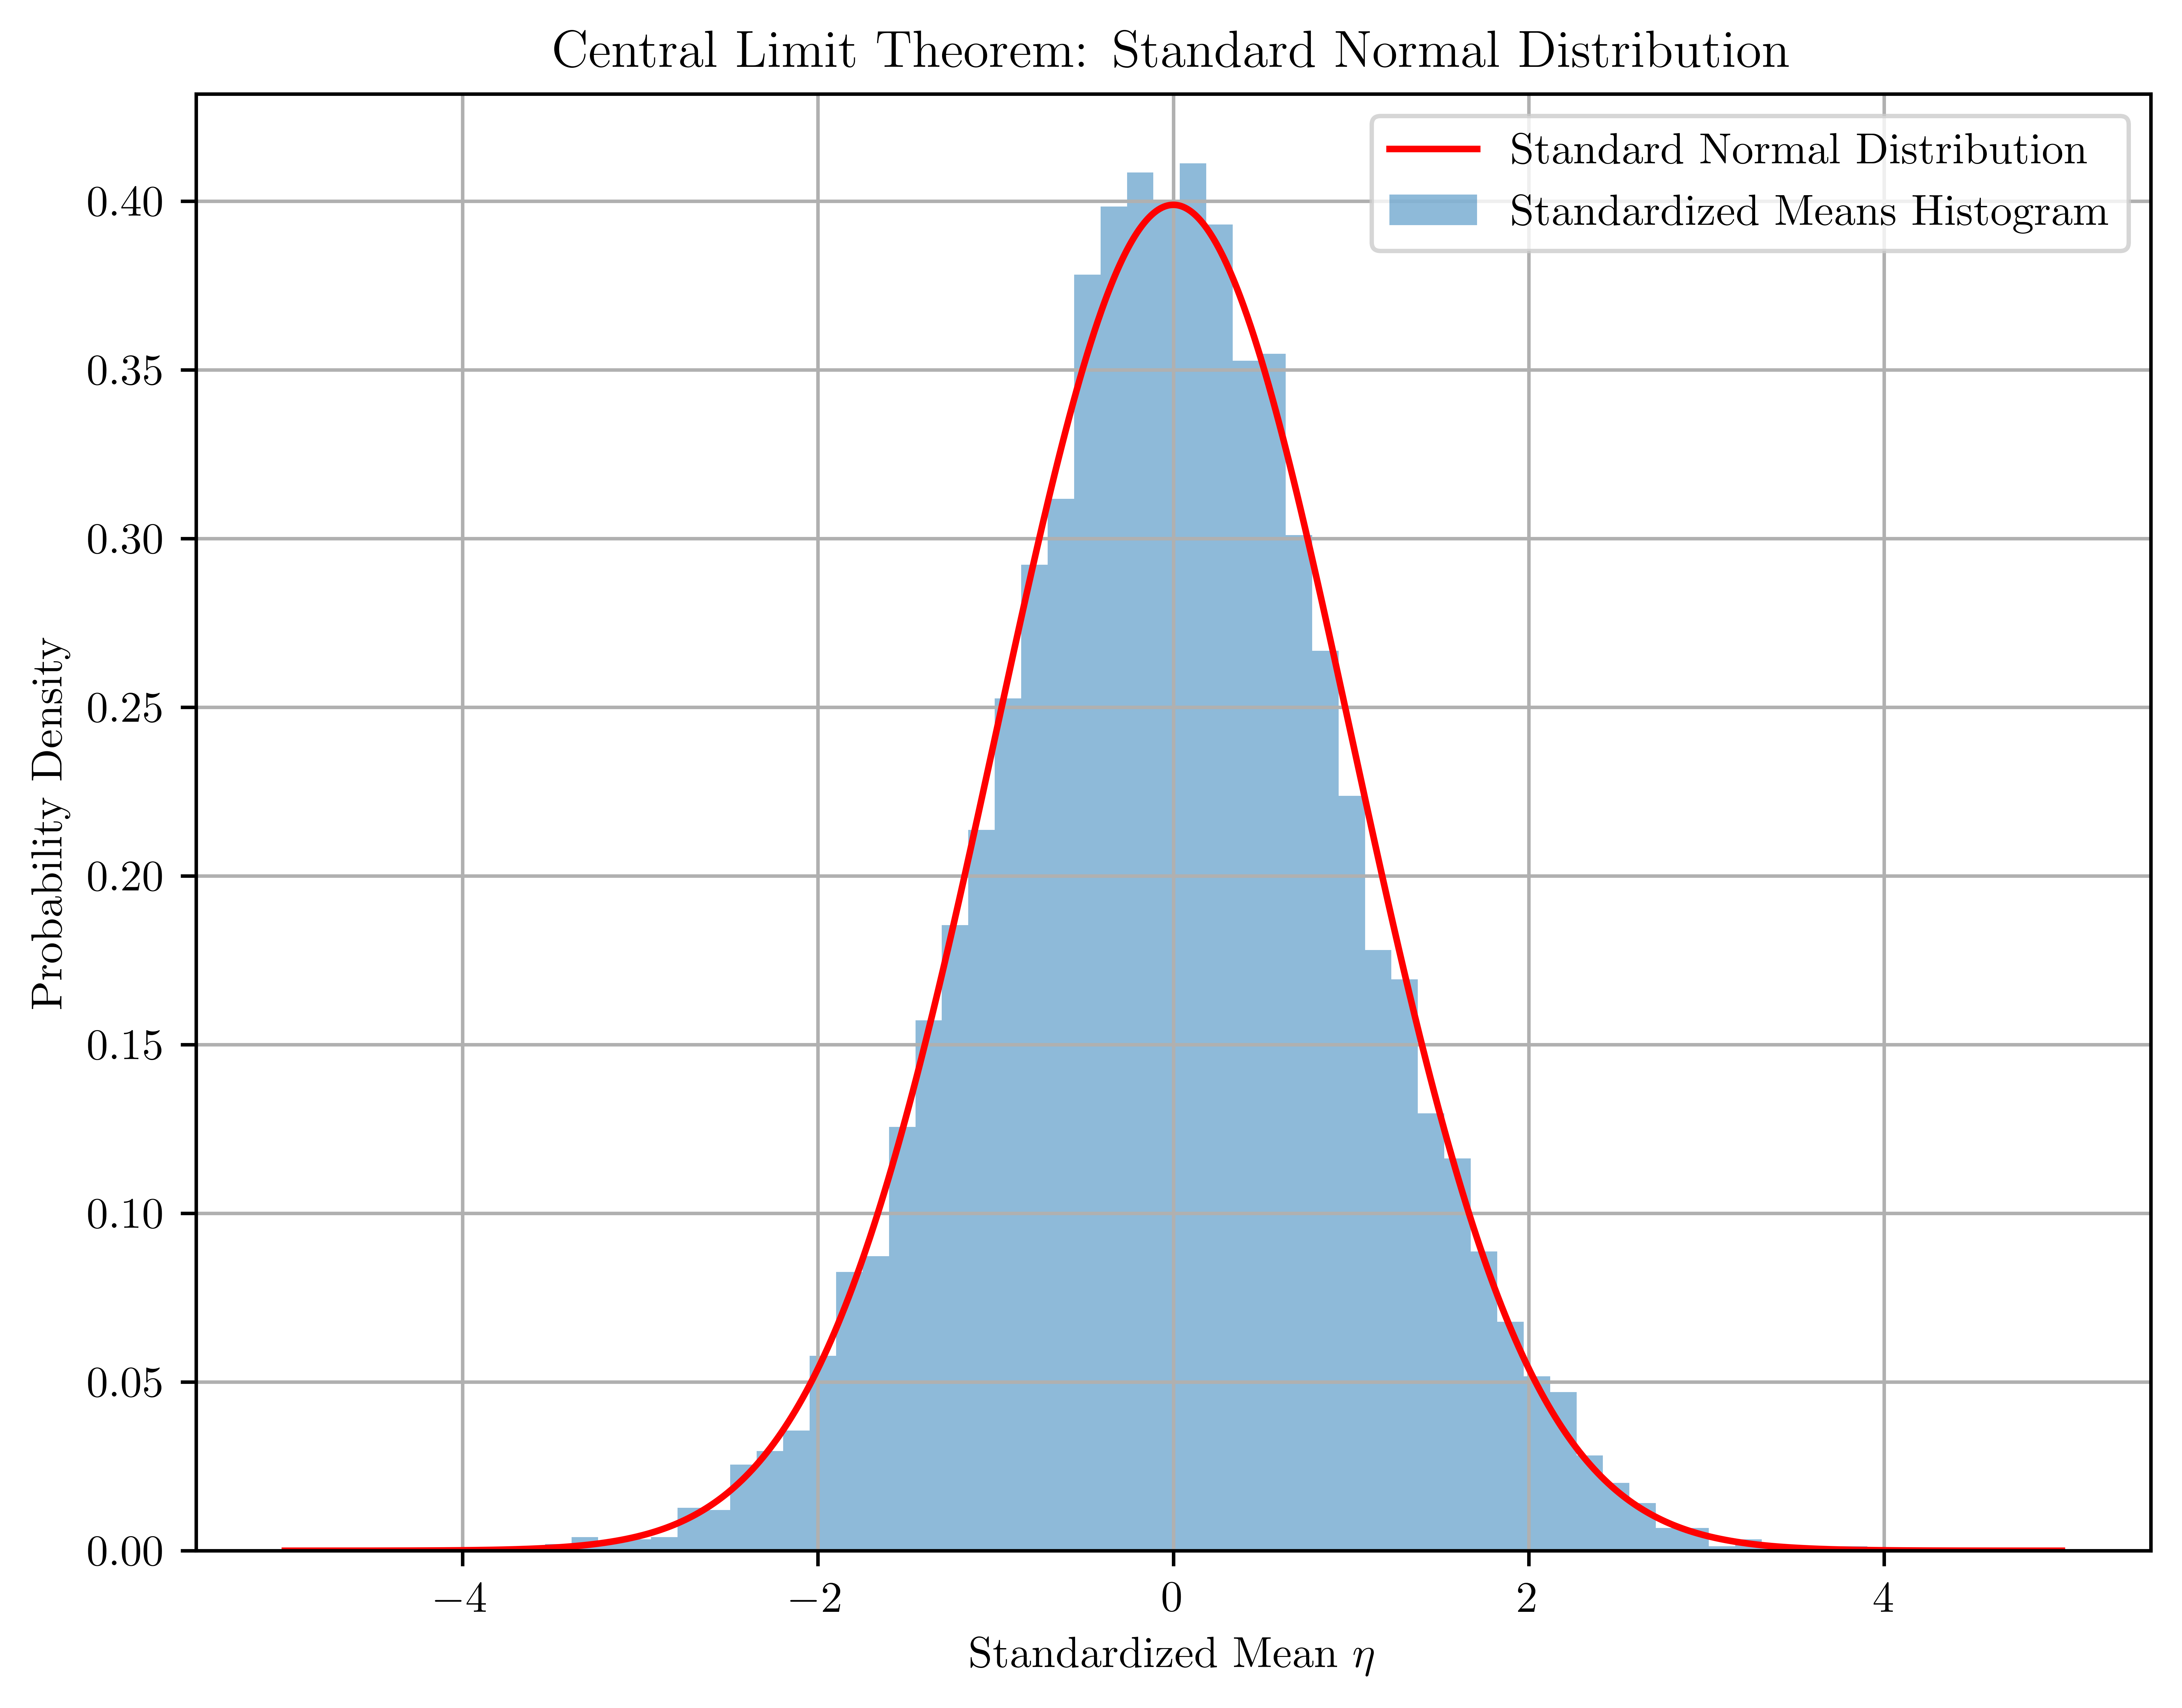

In [34]:
sample_size=10000
N_exp=10000

# Generate sample means
CLT_means = [np.mean(sample_energy_inverse_transform(sample_size, beta)) for _ in range(N_exp)]

# Compute mean and variance of the sample means
CLT_mean = np.mean(CLT_means)
CLT_var = np.var(CLT_means)

# Standardize the sample means
standardized_means = (CLT_means - CLT_mean) / np.sqrt(CLT_var)

# Histogram of standardized means
hist, bin_edges = np.histogram(standardized_means, bins=50, density=True)
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])

# Generate the standard normal PDF (Gaussian)
eta = np.linspace(-5, 5, 1000)  # Range for the Gaussian plot
gaussian_pdf = (1 / np.sqrt(2 * np.pi)) * np.exp(-(eta ** 2) / 2)

# Plot the histogram and Gaussian fit
plt.figure(figsize=(8, 6), dpi=1000)
plt.bar(bin_centers, hist, width=(bin_edges[1] - bin_edges[0]), alpha=0.5, label='Standardized Means Histogram')
plt.plot(eta, gaussian_pdf, 'r-', label='Standard Normal Distribution')
plt.xlabel(r"Standardized Mean $\eta$")
plt.ylabel("Probability Density")
plt.title("Central Limit Theorem: Standard Normal Distribution")
plt.legend()
plt.grid(True)
plt.show()


In [36]:
print(np.var(CLT_means))
print(np.var(standardized_means))

8.777453001443535e-48
0.9999999999999997


## Task 3 - X^2 distribution

### a) Expected pdf

What is the expected p.d.f. for the number of entries per bin?

(100,)
(1000,)
(100,)
1000
100


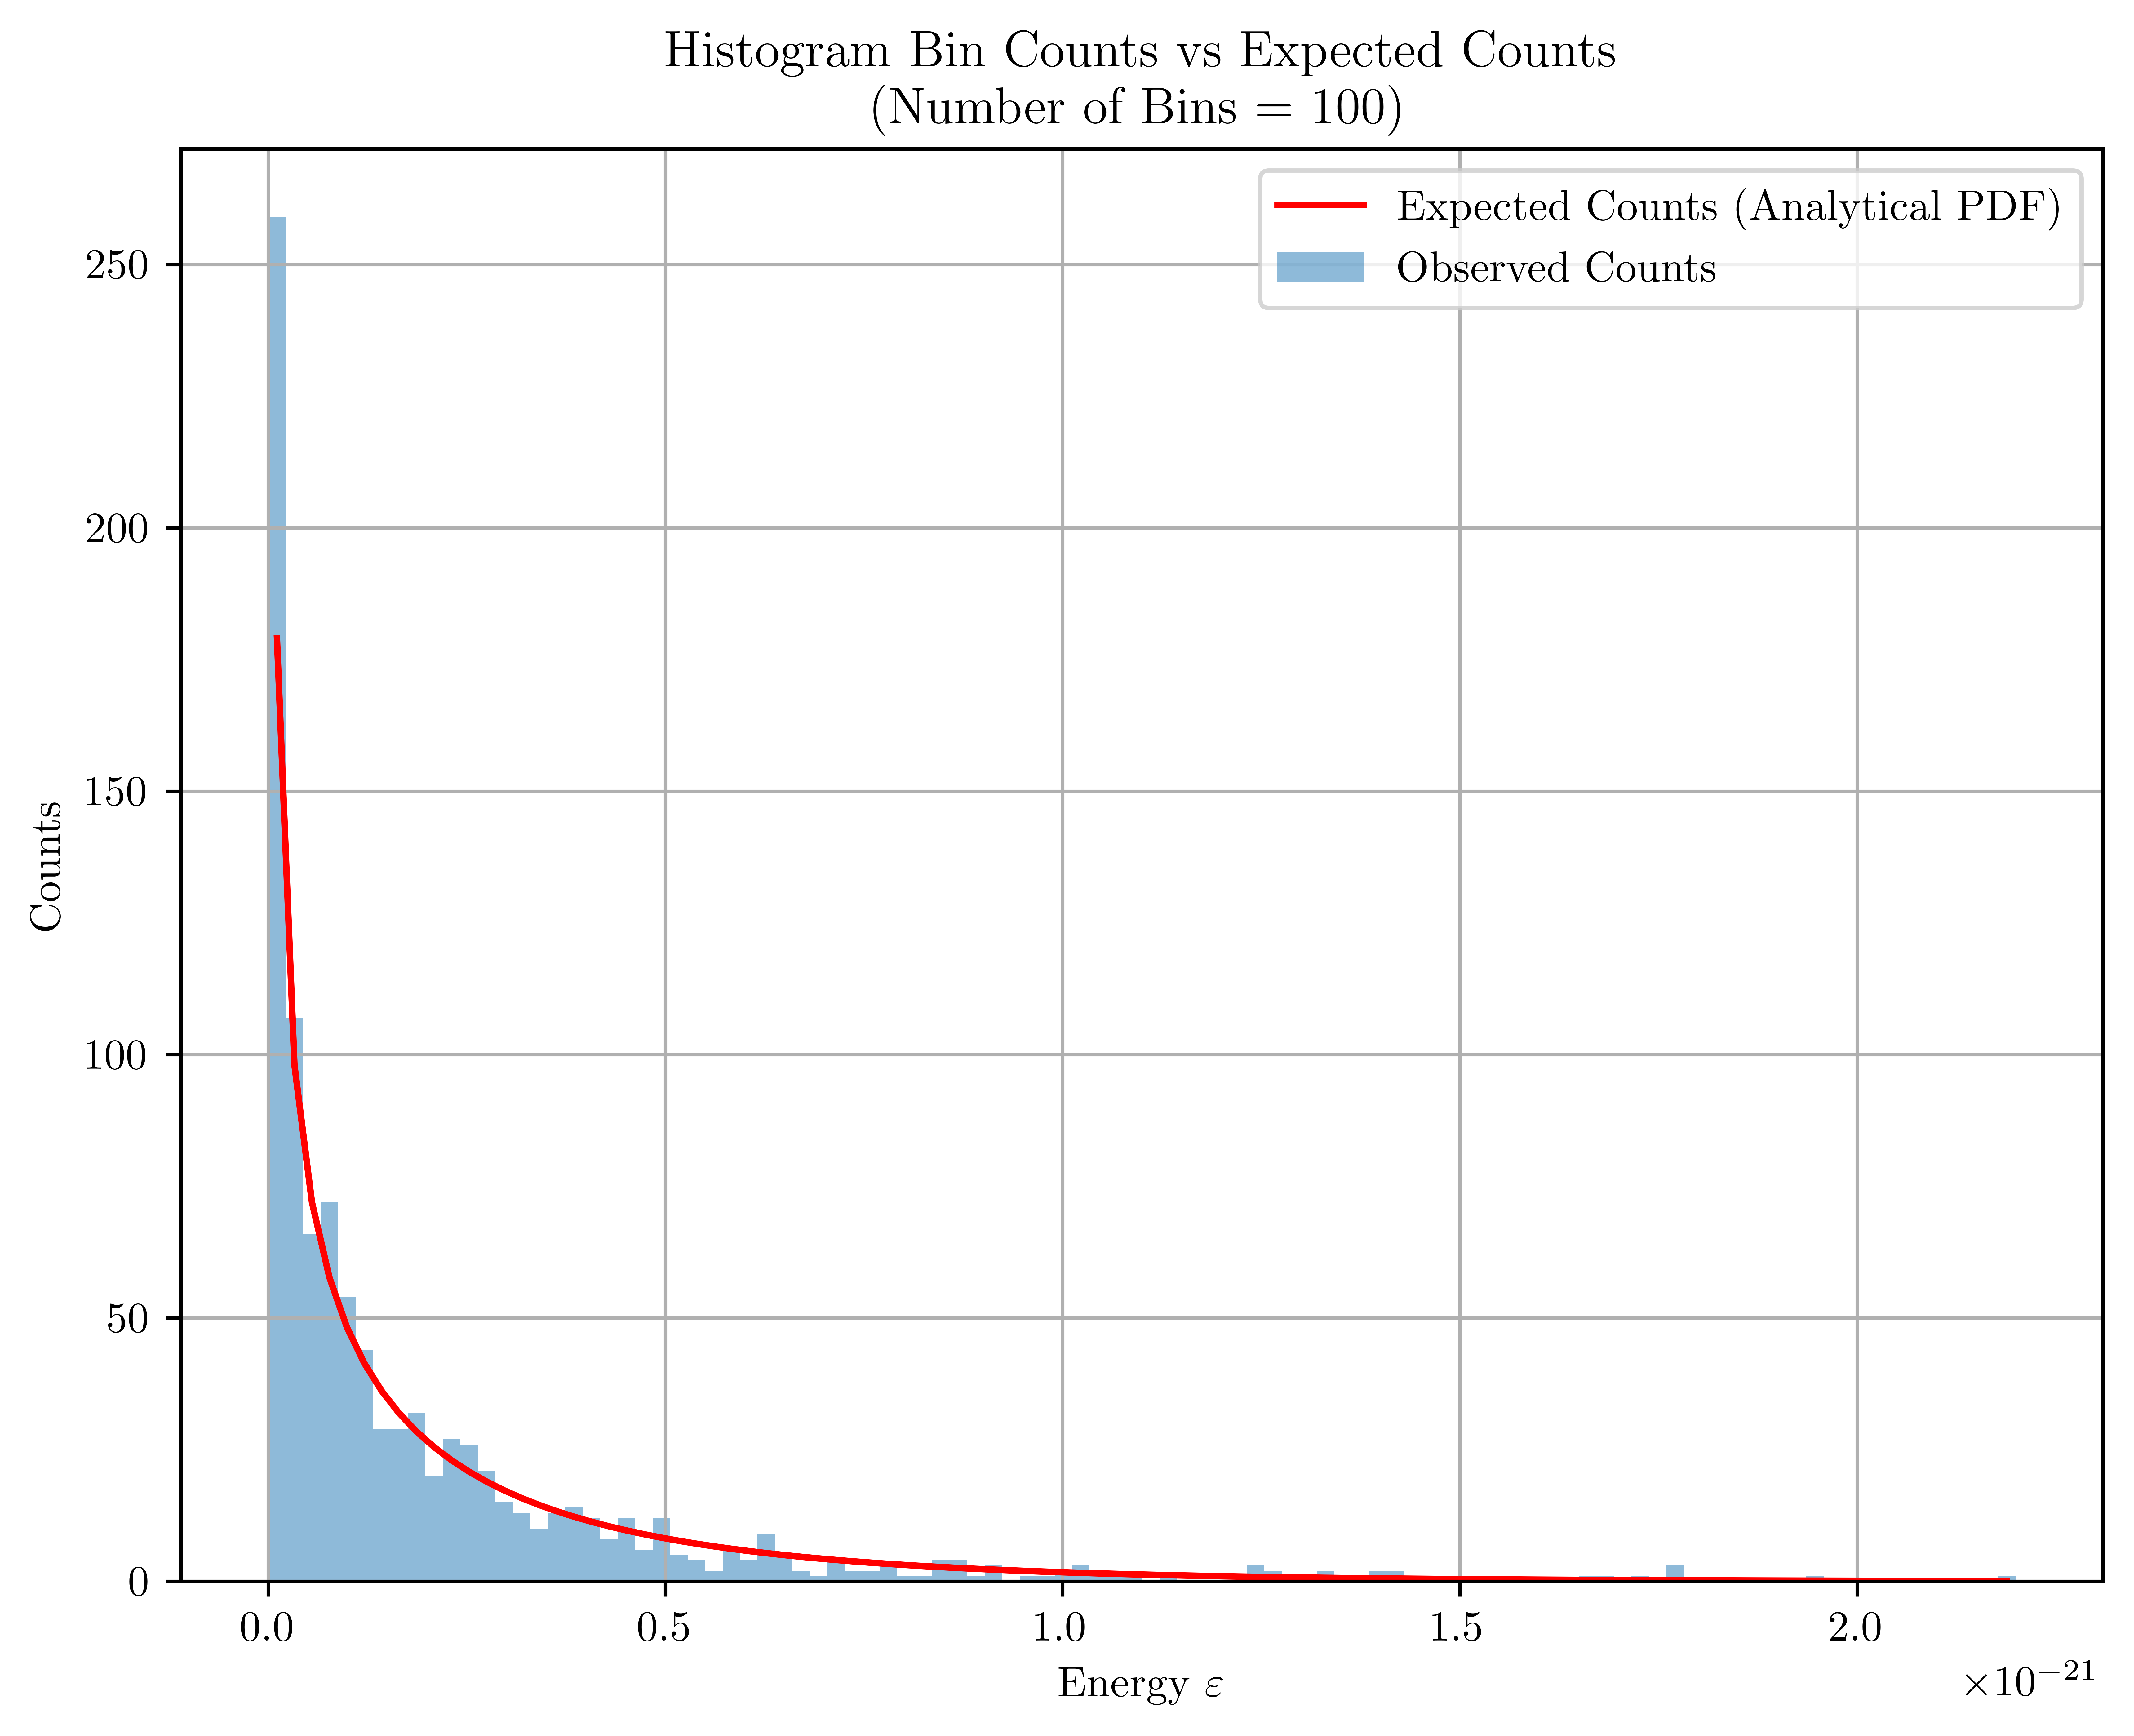

In [93]:
N_exp = 1
N = 1000
bin = 100

energy_values = sample_energy_inverse_transform(N, beta)


hist, bin_edges = np.histogram(energy_values, bins=bin, range=(0, np.percentile(energy_values, 99.9)), density=False)
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
bin_width = bin_edges[1] - bin_edges[0]  # Width of each bin


print(bin_centers.shape)
expected_counts = pdf(bin_centers, beta) * bin_width * N

print(energy_values.shape)
print(expected_counts.shape)
print(len(energy_values))
print(len(expected_counts))

plt.figure(figsize=(8, 6), dpi=1000)
plt.bar(bin_centers, hist, width=bin_width, alpha=0.5, label="Observed Counts")
plt.plot(bin_centers, expected_counts, 'r-', label="Expected Counts (Analytical PDF)")
plt.xlabel(r"Energy $\varepsilon$")
plt.ylabel("Counts")
plt.title(f"Histogram Bin Counts vs Expected Counts\n(Number of Bins = {bin})")
plt.legend()
plt.grid(True)
plt.show()


### b) Show distribution

Show that the  2 of the obtained entries per bin follows a  2 distribution. Instead of
calculating the empirical mean value per bin from the experiments, use the nominal value
from the p.d.f. formula per bin as the mean value per bin

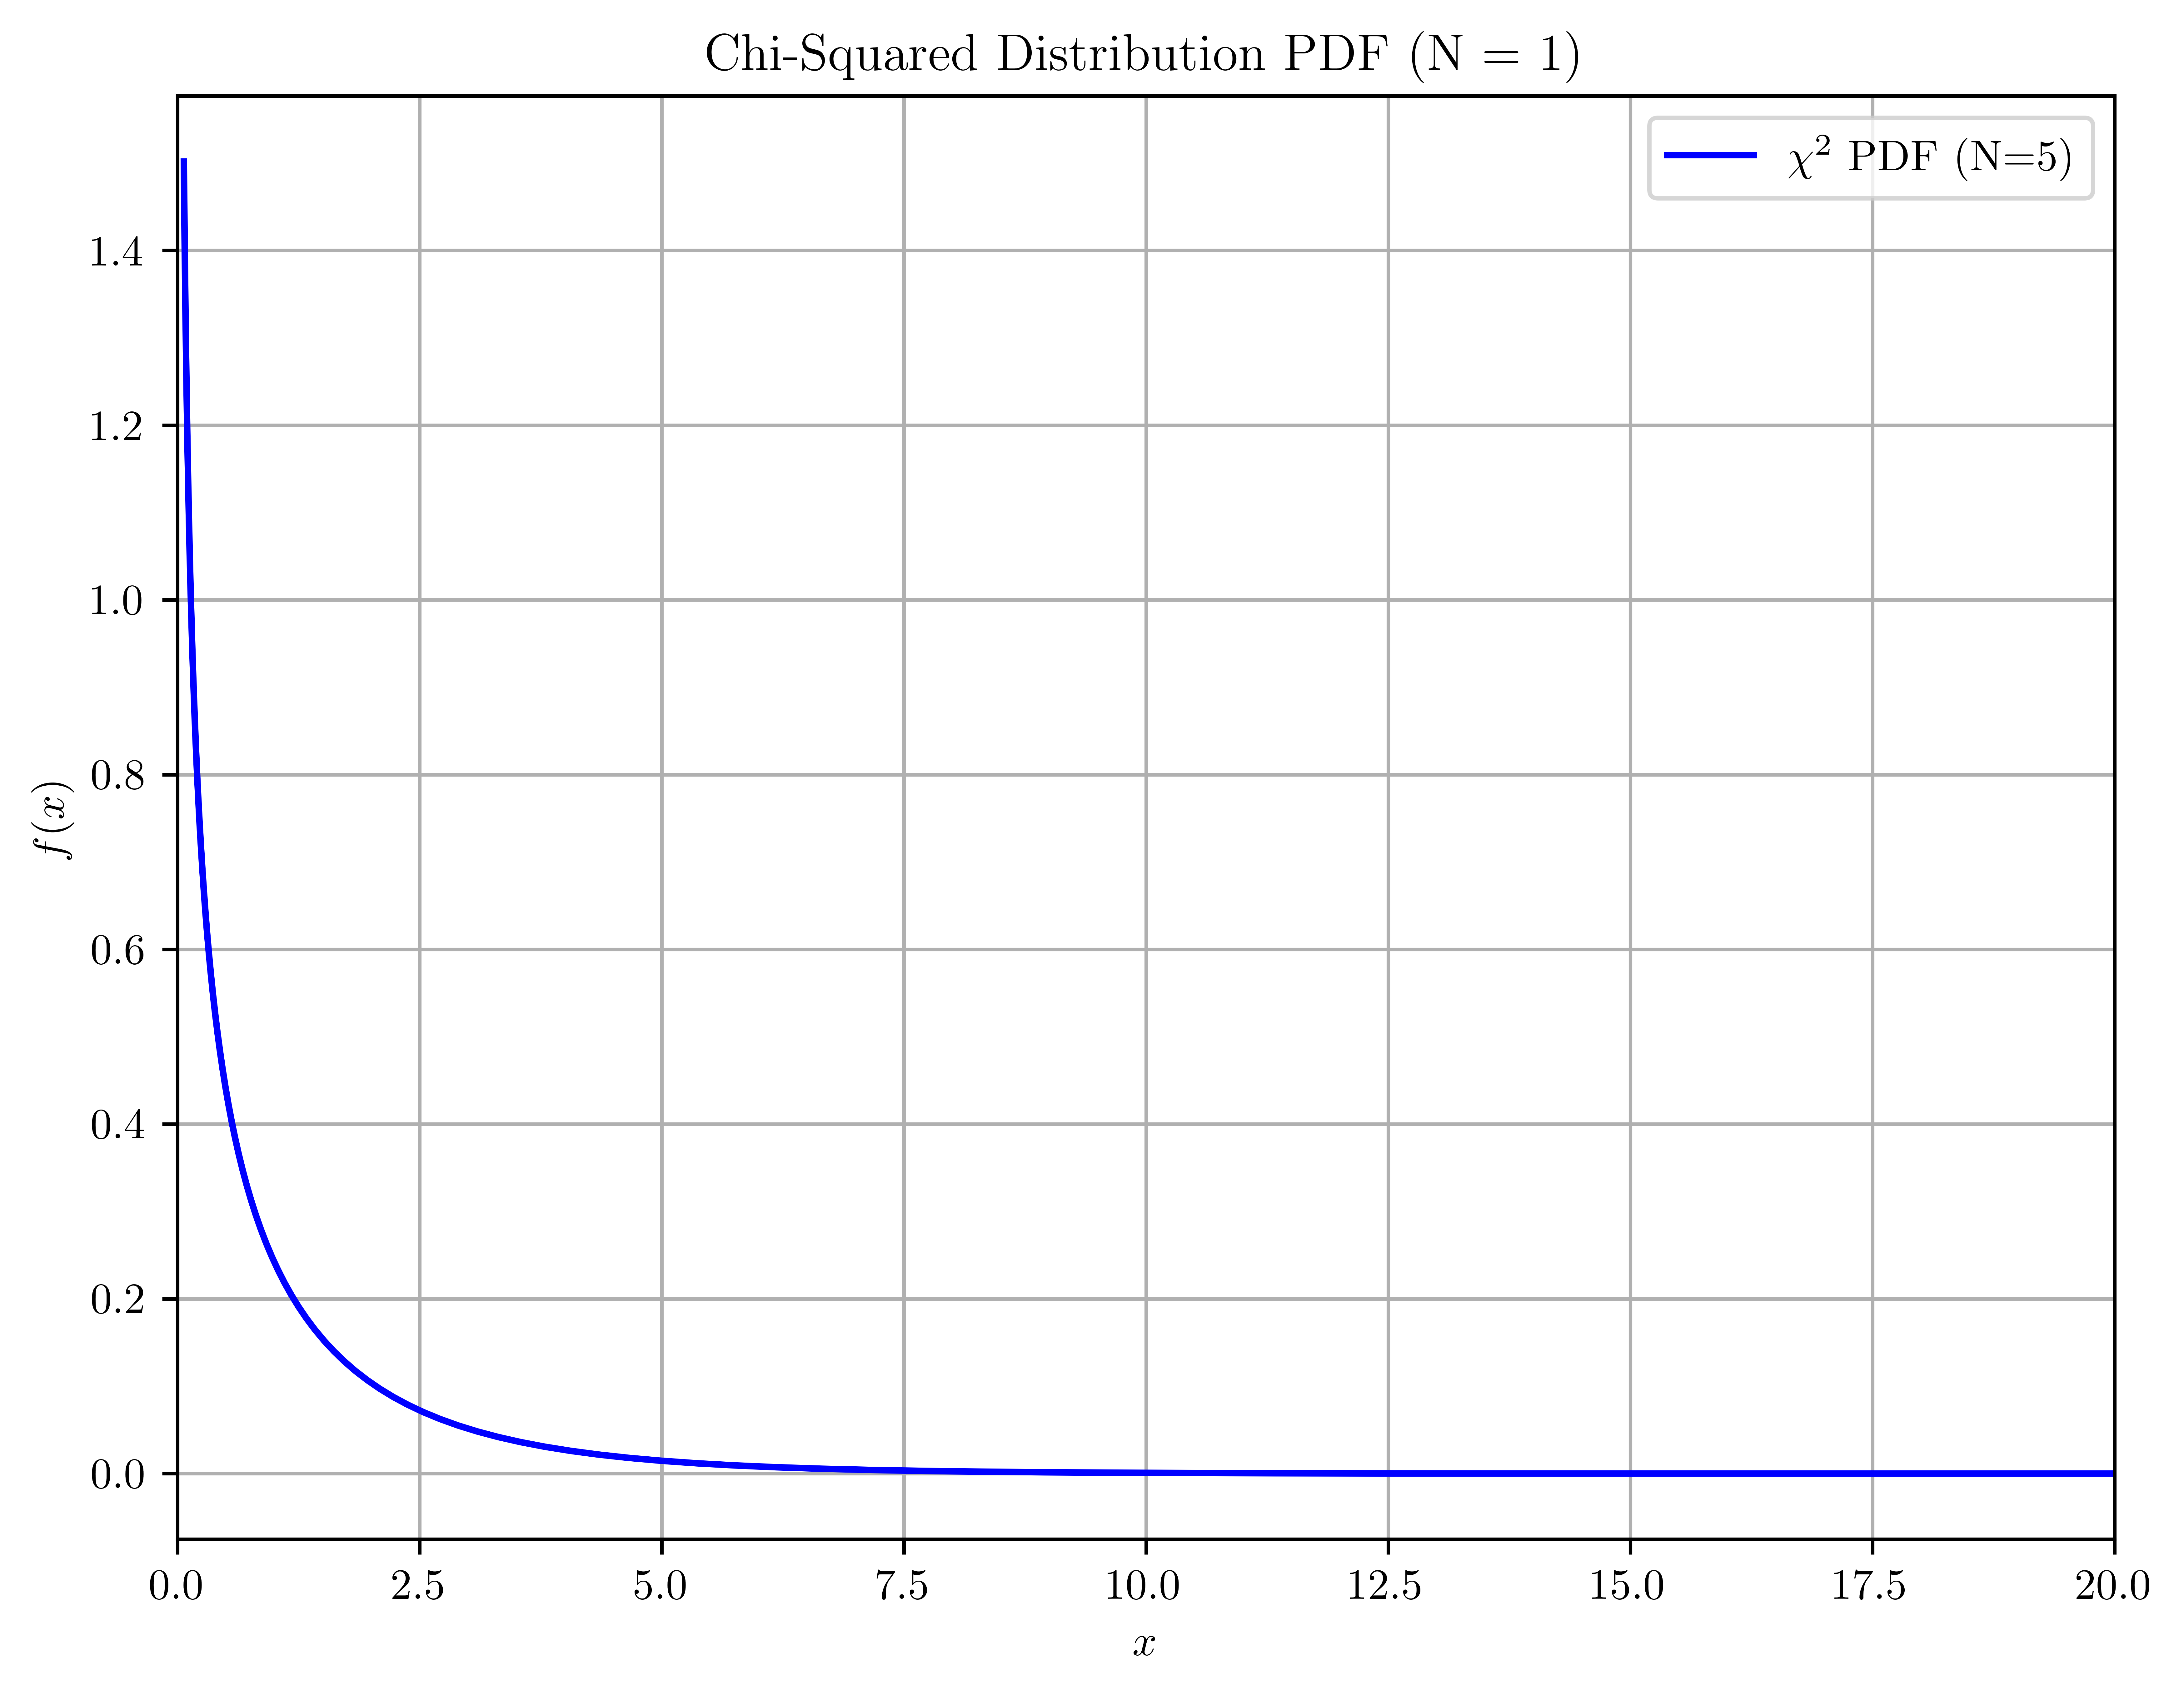

In [110]:
def chi_squared_pdf(x, N):
   
    if N <= 0:
        raise ValueError("Degrees of freedom (N) must be a positive integer.")
    
    x = np.asarray(x)  # Ensure x is a NumPy array for vectorized operations
    pdf = np.zeros_like(x)  # Initialize PDF with zeros for x < 0
    valid_indices = x > 0  # Only calculate where x > 0
    pdf[valid_indices] = (
        (1 / (2 ** (N / 2) * gamma(N / 2))) * 
        (x[valid_indices] ** ((N / 2) - 1)) * 
        np.exp(-x[valid_indices] / 2)
    )
    return pdf



# Parameters
N = 1  # Degrees of freedom


x = expected_counts

# Compute the PDF
pdf_values = chi_squared_pdf(x, N)

# Plot the PDF
plt.figure(figsize=(8, 6), dpi=1000)
plt.plot(x, pdf_values, label=r"$\chi^2$ PDF (N=5)", color="blue")
plt.xlabel(r"$x$")
plt.ylabel(r"$f(x)$")
plt.xlim(right=20)
plt.xlim(left=0)
plt.title(f"Chi-Squared Distribution PDF (N = {N})")
plt.legend()
plt.grid(True)
plt.show()

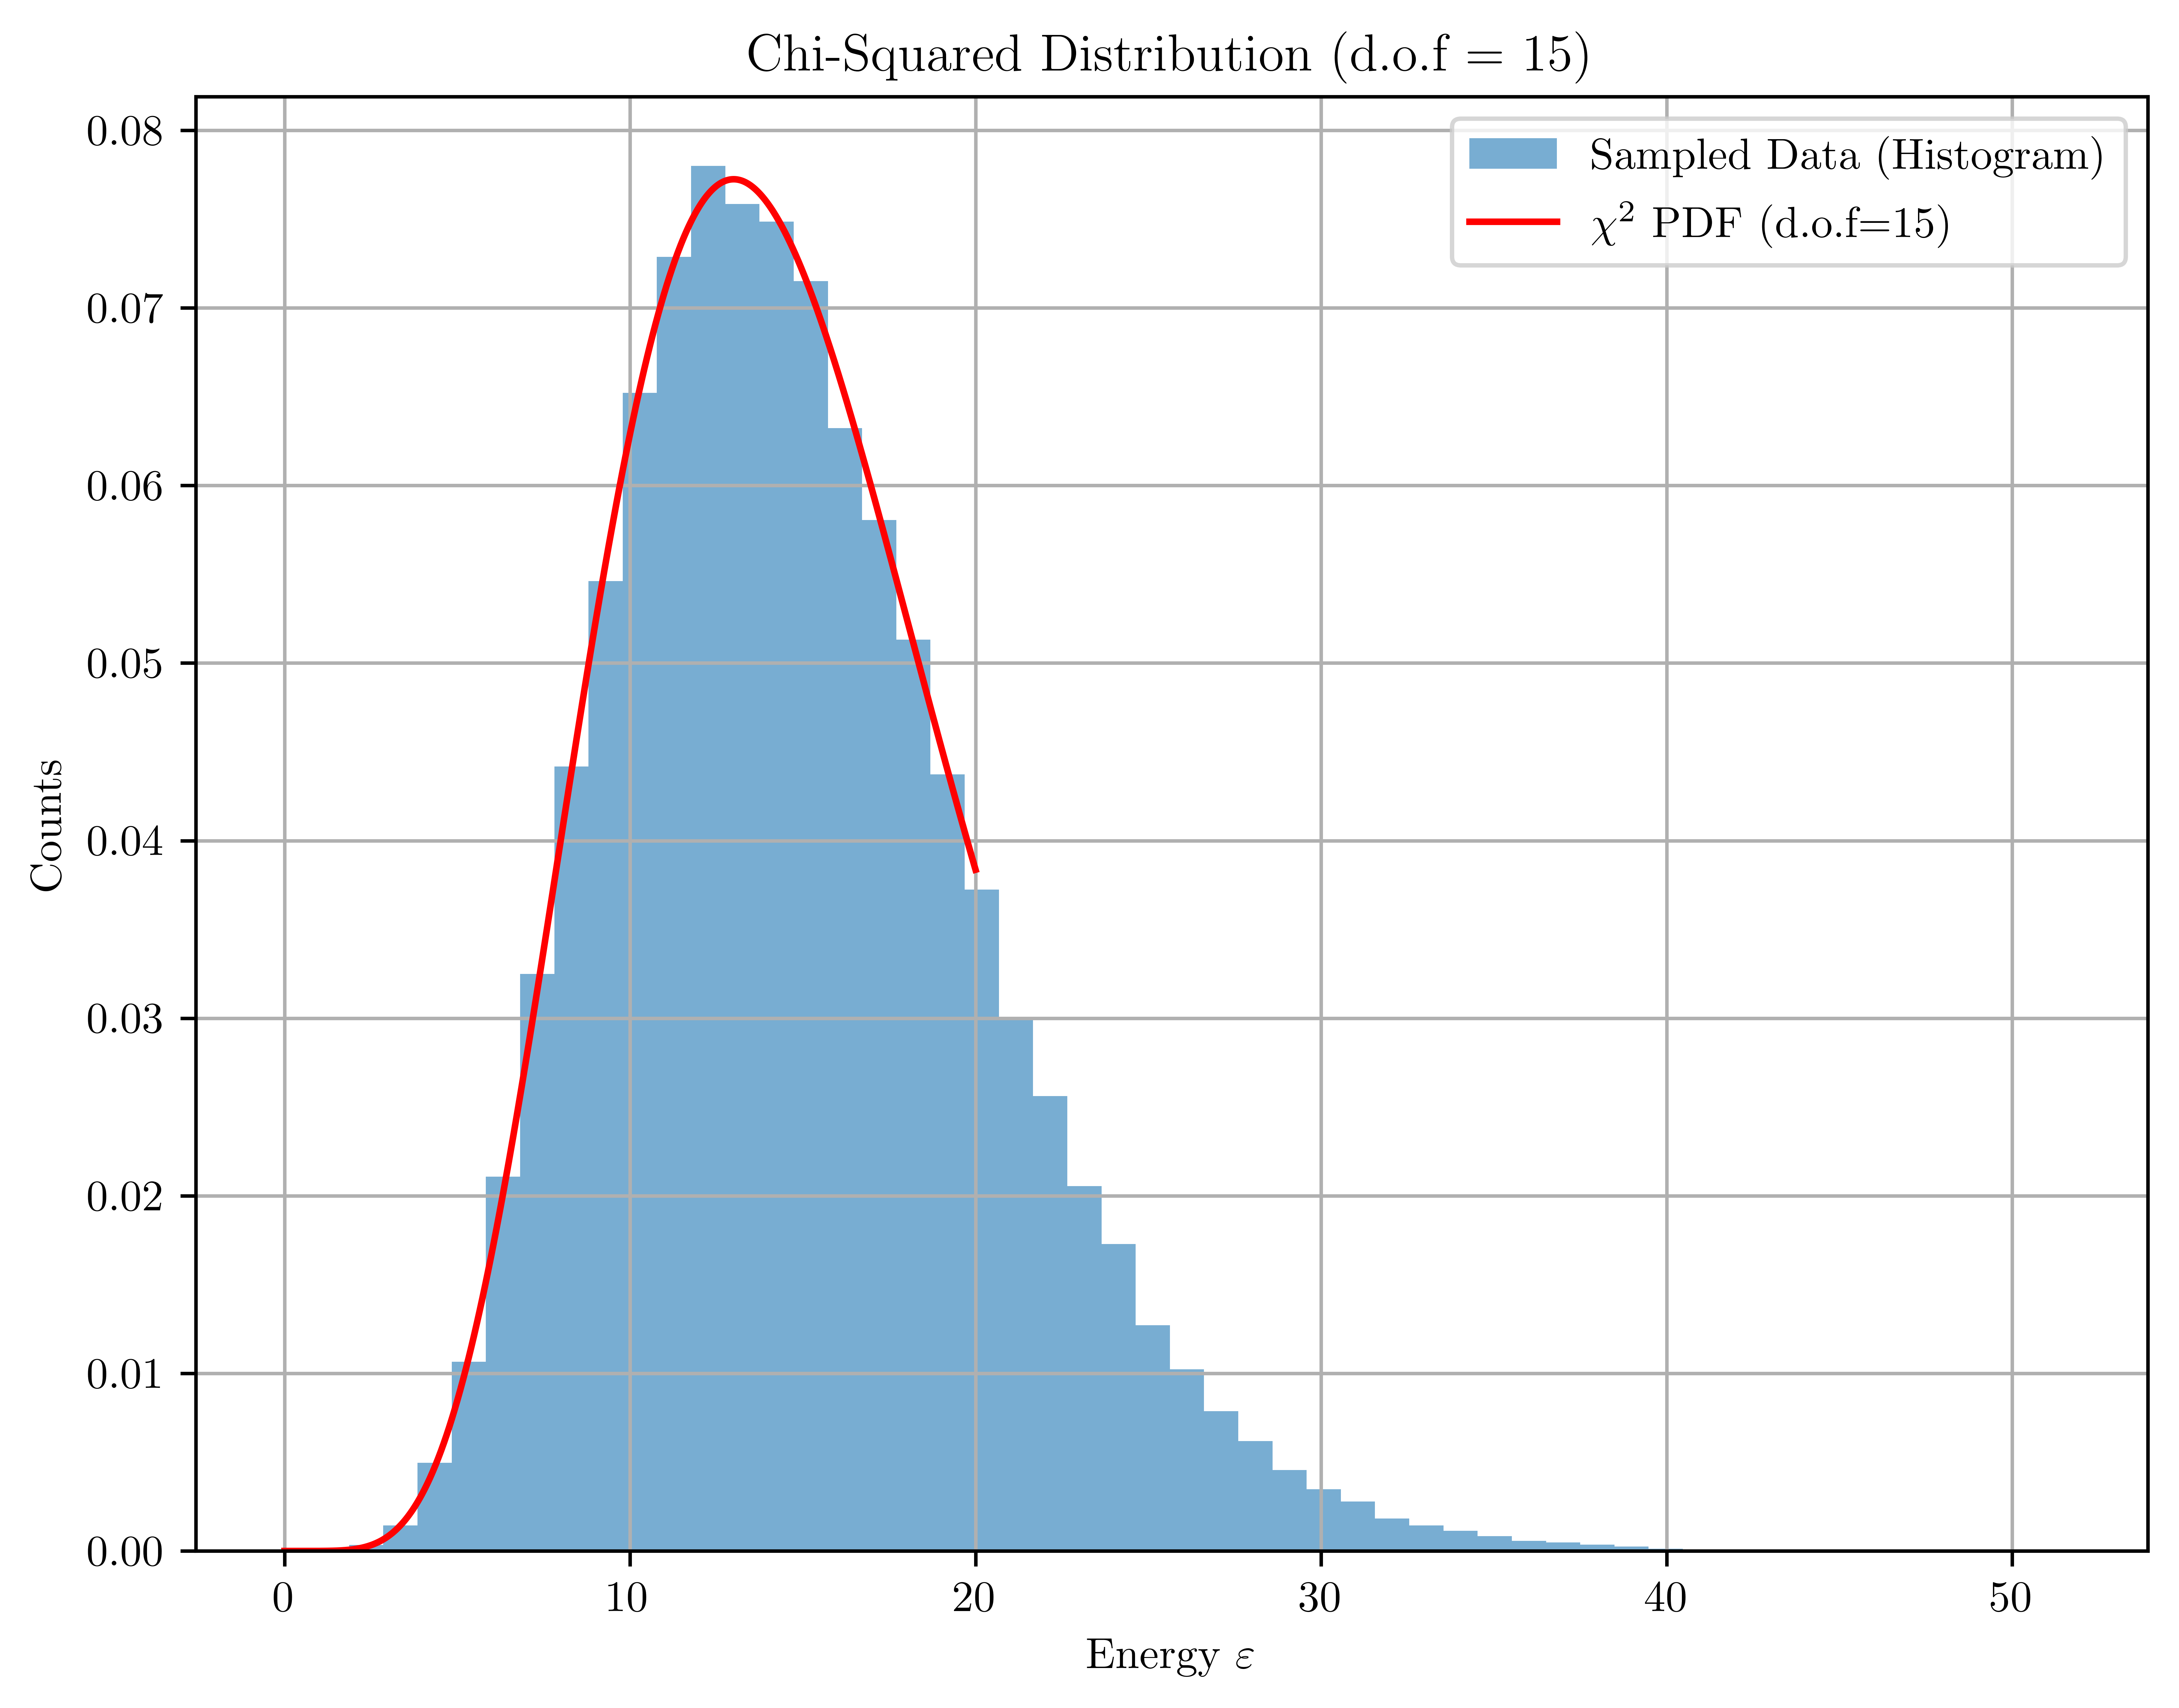

In [120]:
# Function to compute chi-squared PDF
def chi_squared_pdf(x, N):
    """PDF of the chi-squared distribution."""
    if N <= 0:
        raise ValueError("Degrees of freedom (N) must be a positive integer.")
    
    x = np.asarray(x)  # Ensure x is a NumPy array for vectorized operations
    pdf = np.zeros_like(x)  # Initialize PDF with zeros for x < 0
    valid_indices = x > 0  # Only calculate where x > 0
    pdf[valid_indices] = (
        (1 / (2 ** (N / 2) * gamma(N / 2))) * 
        (x[valid_indices] ** ((N / 2) - 1)) * 
        np.exp(-x[valid_indices] / 2)
    )
    return pdf

# Function to generate samples using the Inverse Transform Method
def sample_chi_squared(N_samples, N):
    """Generate chi-squared samples using the inverse transform method."""
    return np.random.chisquare(N, N_samples)

# Parameters
N = 15  # Degrees of freedom
N_samples = 100000  # Number of samples
bins = 50  # Number of bins in the histogram

# Generate chi-squared samples
samples = sample_chi_squared(N_samples, N)

# Compute the PDF
x = np.linspace(0, 20, 500)  # Range of x-values
pdf_values = chi_squared_pdf(x, N)

# Plot the histogram and PDF
plt.figure(figsize=(8, 6), dpi=1000)

# Histogram of generated samples
plt.hist(samples, bins=bins, density=True, alpha=0.6, label="Sampled Data (Histogram)")

# Chi-squared PDF
plt.plot(x, pdf_values, label=f"$\chi^2$ PDF (d.o.f={N})", color="red")

# Formatting
plt.xlabel(r"Energy $\varepsilon$")
plt.ylabel("Counts")
plt.title(f"Chi-Squared Distribution (d.o.f = {N})")
plt.legend()
plt.grid(True)
plt.show()

## Task 4 - Parameter estimation

a) Compute the log likelihood ln L(E!,1, E!,2, ..., E!,N | T ) at a given T . Then, use the
maximum likelihood method to estimate T and its variance.

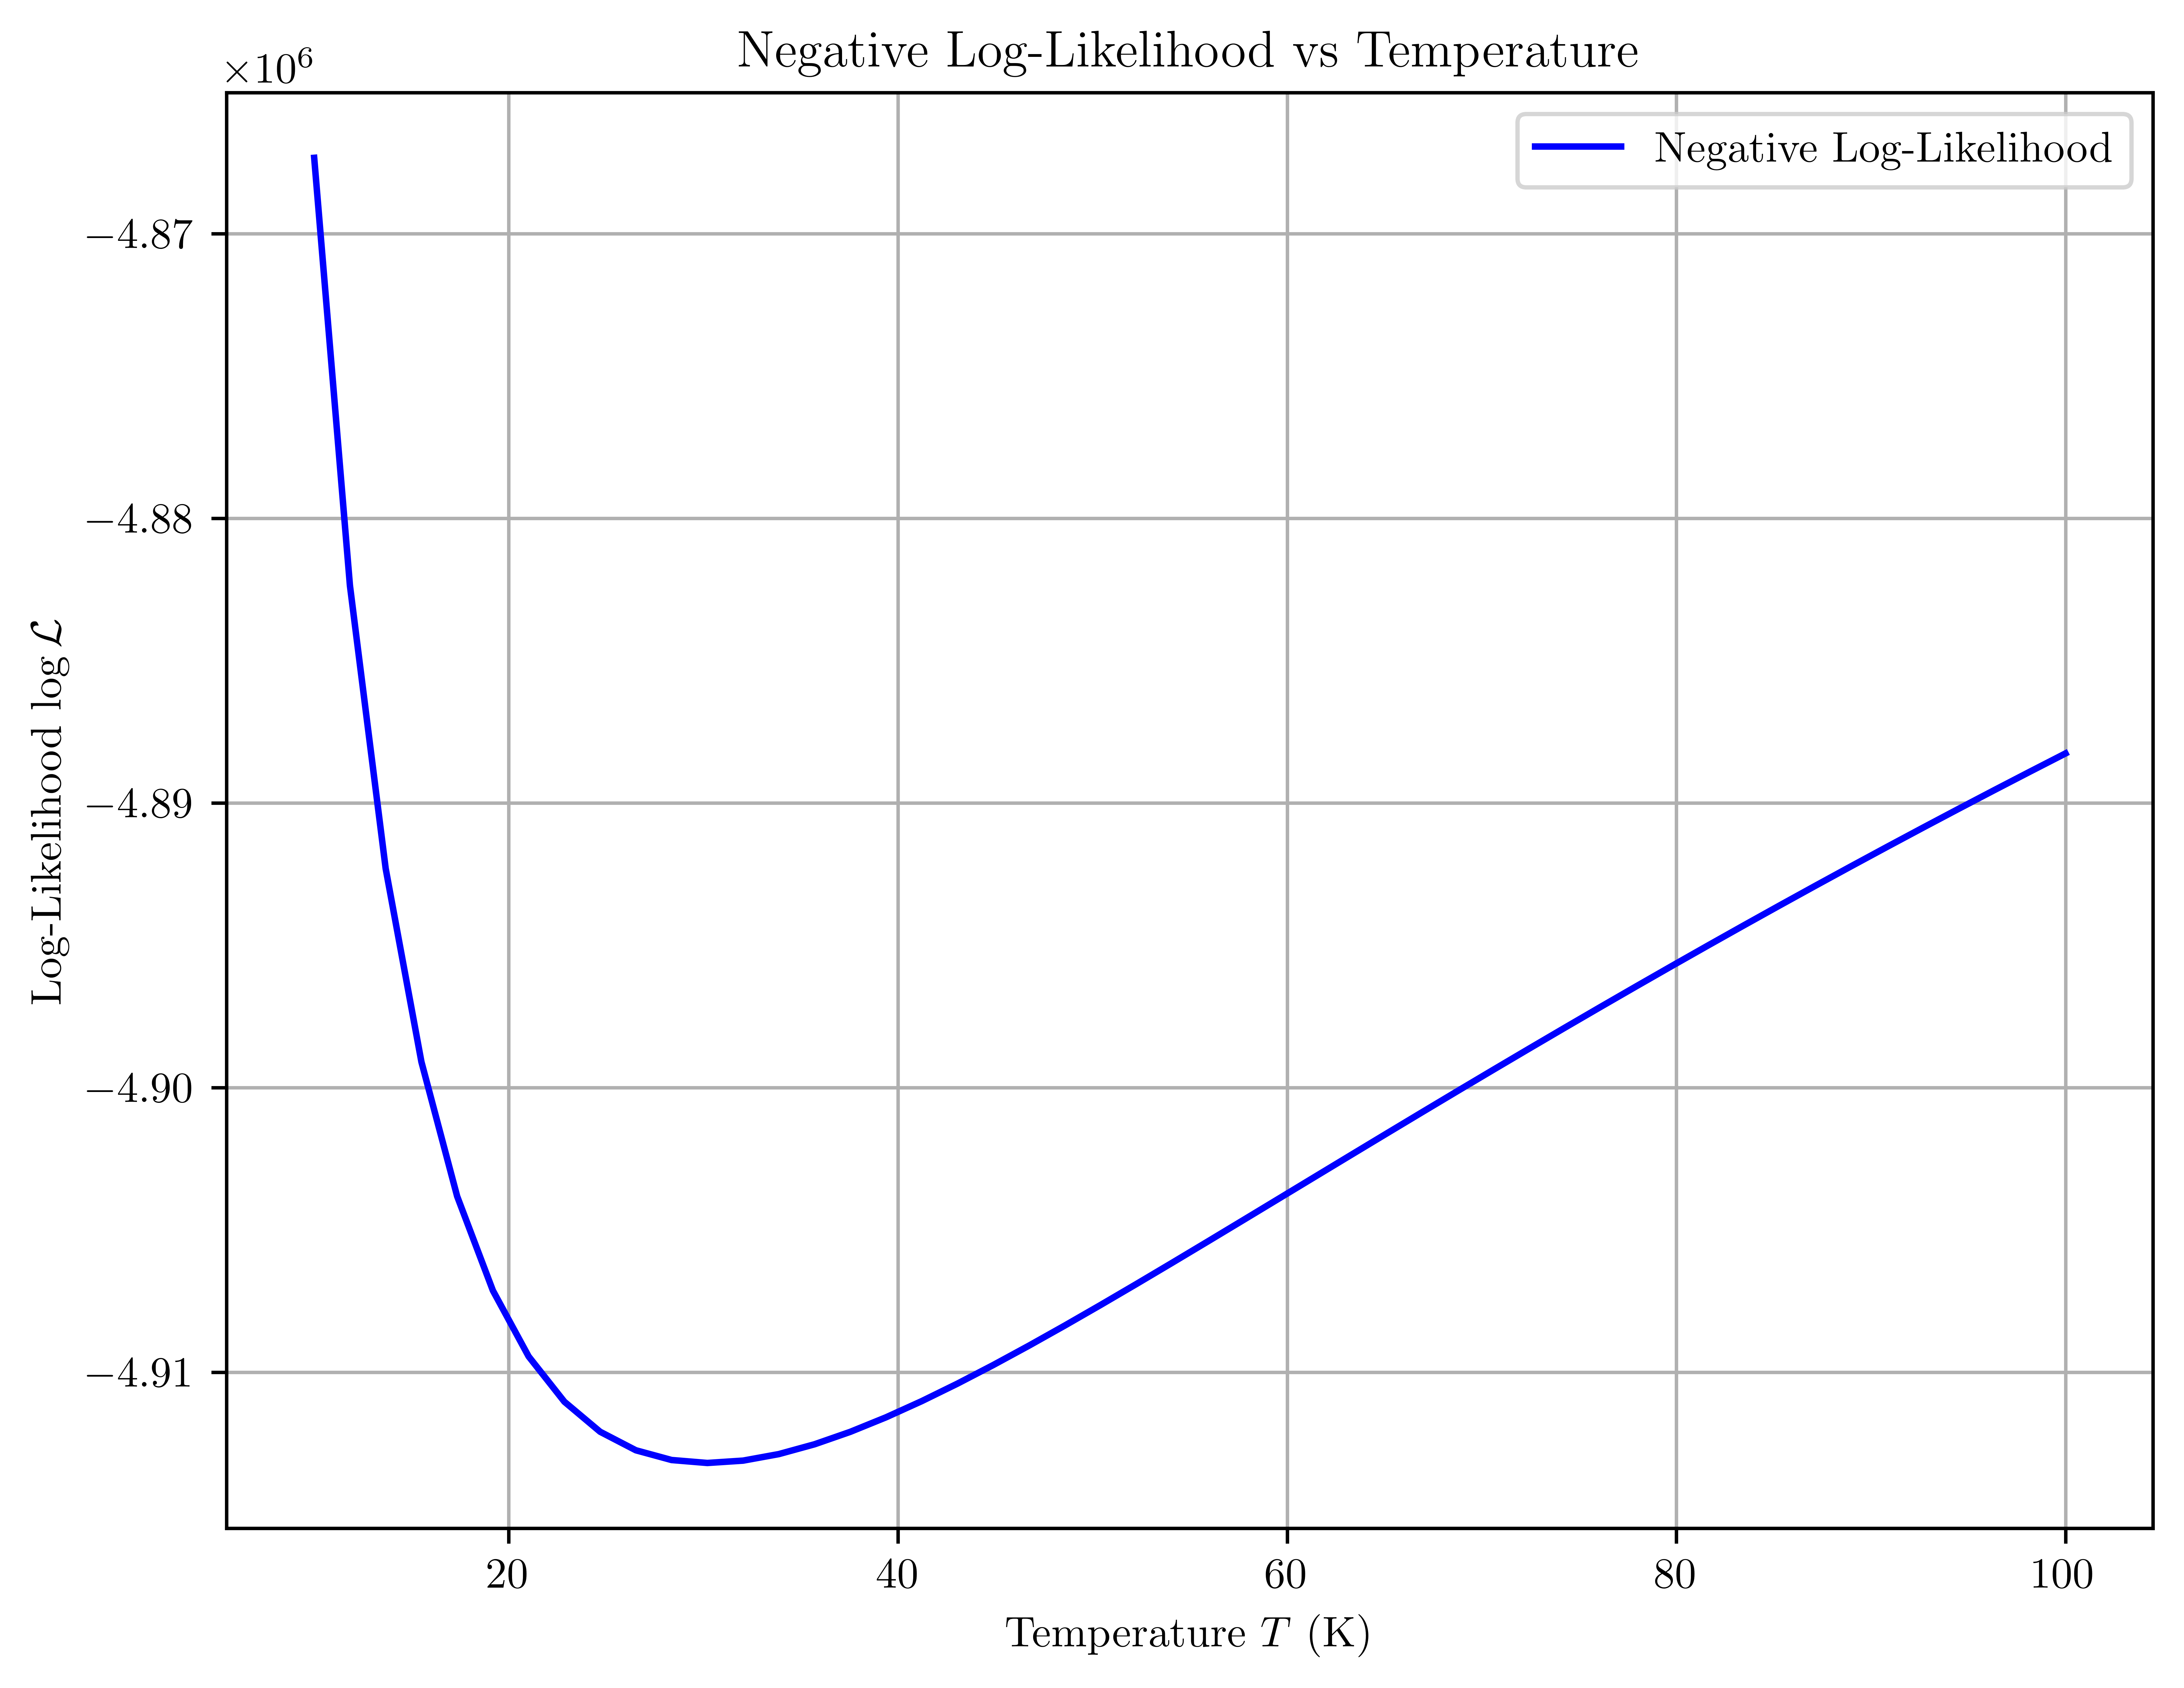

In [133]:
beta = 1/(kb*T)
k_B = 1.3806e-23  # Boltzmann constant (J/K)
N = 100000  # Number of energy samples
T_values = np.linspace(1, 5000, 10000)  # Temperature range in Kelvin
log_likelihoods = []

def compute_log_likelihood(data, beta):
   
    # Ensure no values are zero or negative to avoid log issues
    if np.any(data <= 0):
        raise ValueError("All data points must be positive.")
    
    # Compute log(PDF) for each data point
    log_pdf_values = (
        np.log(np.sqrt(beta / np.pi)) - beta * data - 0.5 * np.log(data)
    )
    
    # Sum to get the total log-likelihood
    return np.sum(log_pdf_values)


N = 100000  # Number of energy samples
T_values = np.linspace(10, 100, 50)  # Temperature range in Kelvin
log_likelihoods = []

T_ref = 30  # Reference temperature in Kelvin
beta_ref = 1 / (k_B * T_ref)
energy_samples = sample_energy_inverse_transform(N, beta_ref)

# Compute log-likelihood for each temperature
for T in T_values:
    beta = 1 / (k_B * T)
    log_likelihood = compute_log_likelihood(energy_samples, beta)
    log_likelihoods.append(-log_likelihood)

# Plot log-likelihood vs temperature
plt.figure(figsize=(8, 6), dpi=1000)
plt.plot(T_values, log_likelihoods, label="Negative Log-Likelihood", color="blue")
plt.xlabel(r"Temperature $T$ (K)")
plt.ylabel(r"Log-Likelihood $\log \mathcal{L}$")
plt.title("Negative Log-Likelihood vs Temperature")
plt.legend()
plt.grid(True)
plt.show()


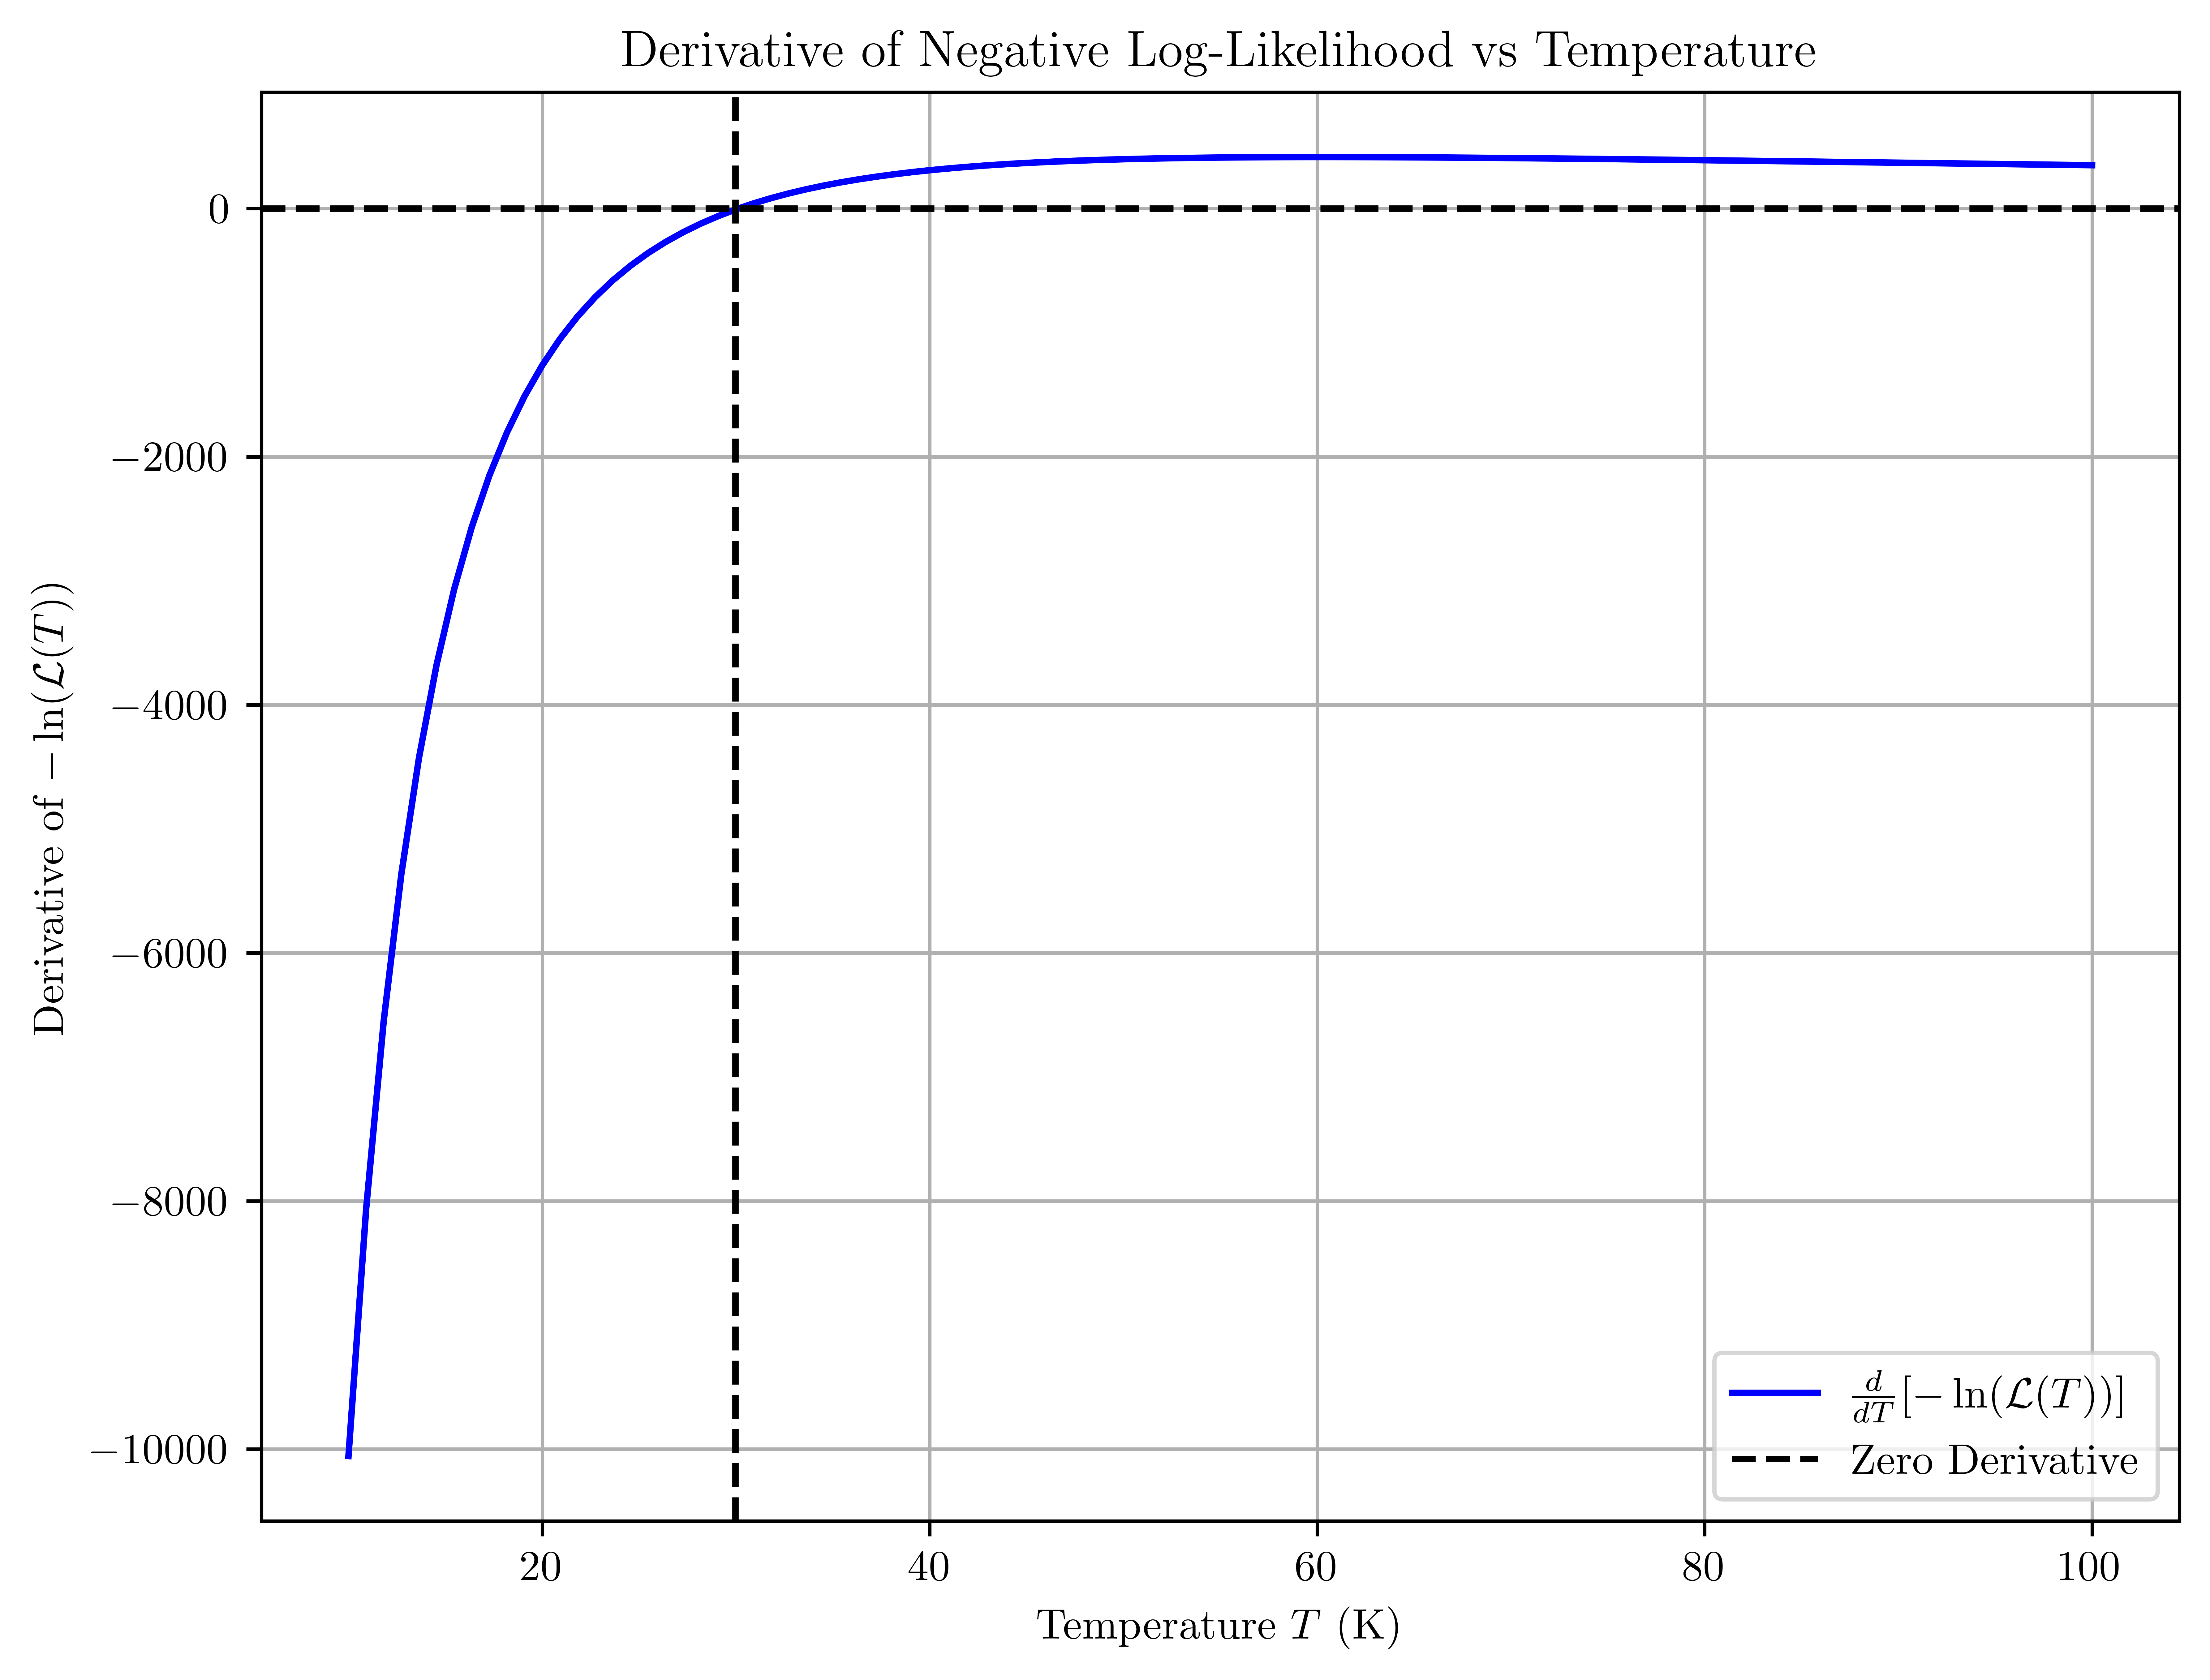

In [ ]:

def derivative_negative_log_likelihood(data, T, k_B):
    if T <= 0:
        raise ValueError("Temperature T must be greater than zero.")
    if np.any(data <= 0):
        raise ValueError("All data points must be positive.")
    
    derivative = np.sum((1 / (2 * T)) - (data / (k_B * T**2)))
    return derivative

N = 100000  # Number of samples
T_values = np.linspace(10, 100, 100)  # Wide range of temperatures in Kelvin

# Generate energy samples at a reference temperature
T_ref = 30  # Reference temperature in Kelvin
beta_ref = 1 / (k_B * T_ref)
energy_samples = sample_energy_inverse_transform(N, beta_ref)

derivatives = []
for T in T_values:
    derivative = derivative_negative_log_likelihood(energy_samples, T, k_B)
    derivatives.append(derivative)

# Plot the derivative
plt.figure(figsize=(8, 6), dpi=1000)
plt.plot(T_values, derivatives, label=r"$\frac{d}{dT}[-\ln(\mathcal{L}(T))]$", color="blue")

plt.axhline(0, color="black", linestyle="--", label="Zero Derivative")

plt.xlabel(r"Temperature $T$ (K)")
plt.ylabel(r"Derivative of $-\ln(\mathcal{L}(T))$")
plt.title("Derivative of Negative Log-Likelihood vs Temperature")
plt.legend()
plt.grid(True)
plt.show()

In [136]:
def root_function(T):
    return derivative_negative_log_likelihood(energy_samples, T, k_B)

# Use root_scalar to find the zero of the derivative
result = root_scalar(root_function, bracket=[10, 100], method='brentq')

if result.converged:
    T_MLE = result.root
    print(f"The maximum likelihood estimate (T_MLE) is: {T_MLE:.5f} K")
else:
    print("Root-finding did not converge.")

The maximum likelihood estimate (T_MLE) is: 29.96988 K


In [140]:
def sample_variance(data):
    """
    Computes the variance of the dataset using the sample variance formula.
    Variance = sum((x_i - mean_x)^2) / N
    """
    mean_x = np.mean(data)
    variance = np.sum((data - mean_x) ** 2) / len(data)
    return variance

# Compute the variance of the energy samples
variance_of_energy_samples = sample_variance(energy_samples)
print(f"Sample Variance of Energy: {variance_of_energy_samples:.5e} J^2")

# Estimate the variance of T_MLE using the relationship between energy and temperature
variance_T_MLE = variance_of_energy_samples / (k_B * T_MLE**2)
print(f"Estimated Variance of T_MLE: {variance_T_MLE:.5e} K^2")

Sample Variance of Energy: 8.56349e-44 J^2
Estimated Variance of T_MLE: 6.90578e-24 K^2


Least Squares Estimate of T (T_best): 26.94901 K
Variance of T_best: 0.00550 K^2


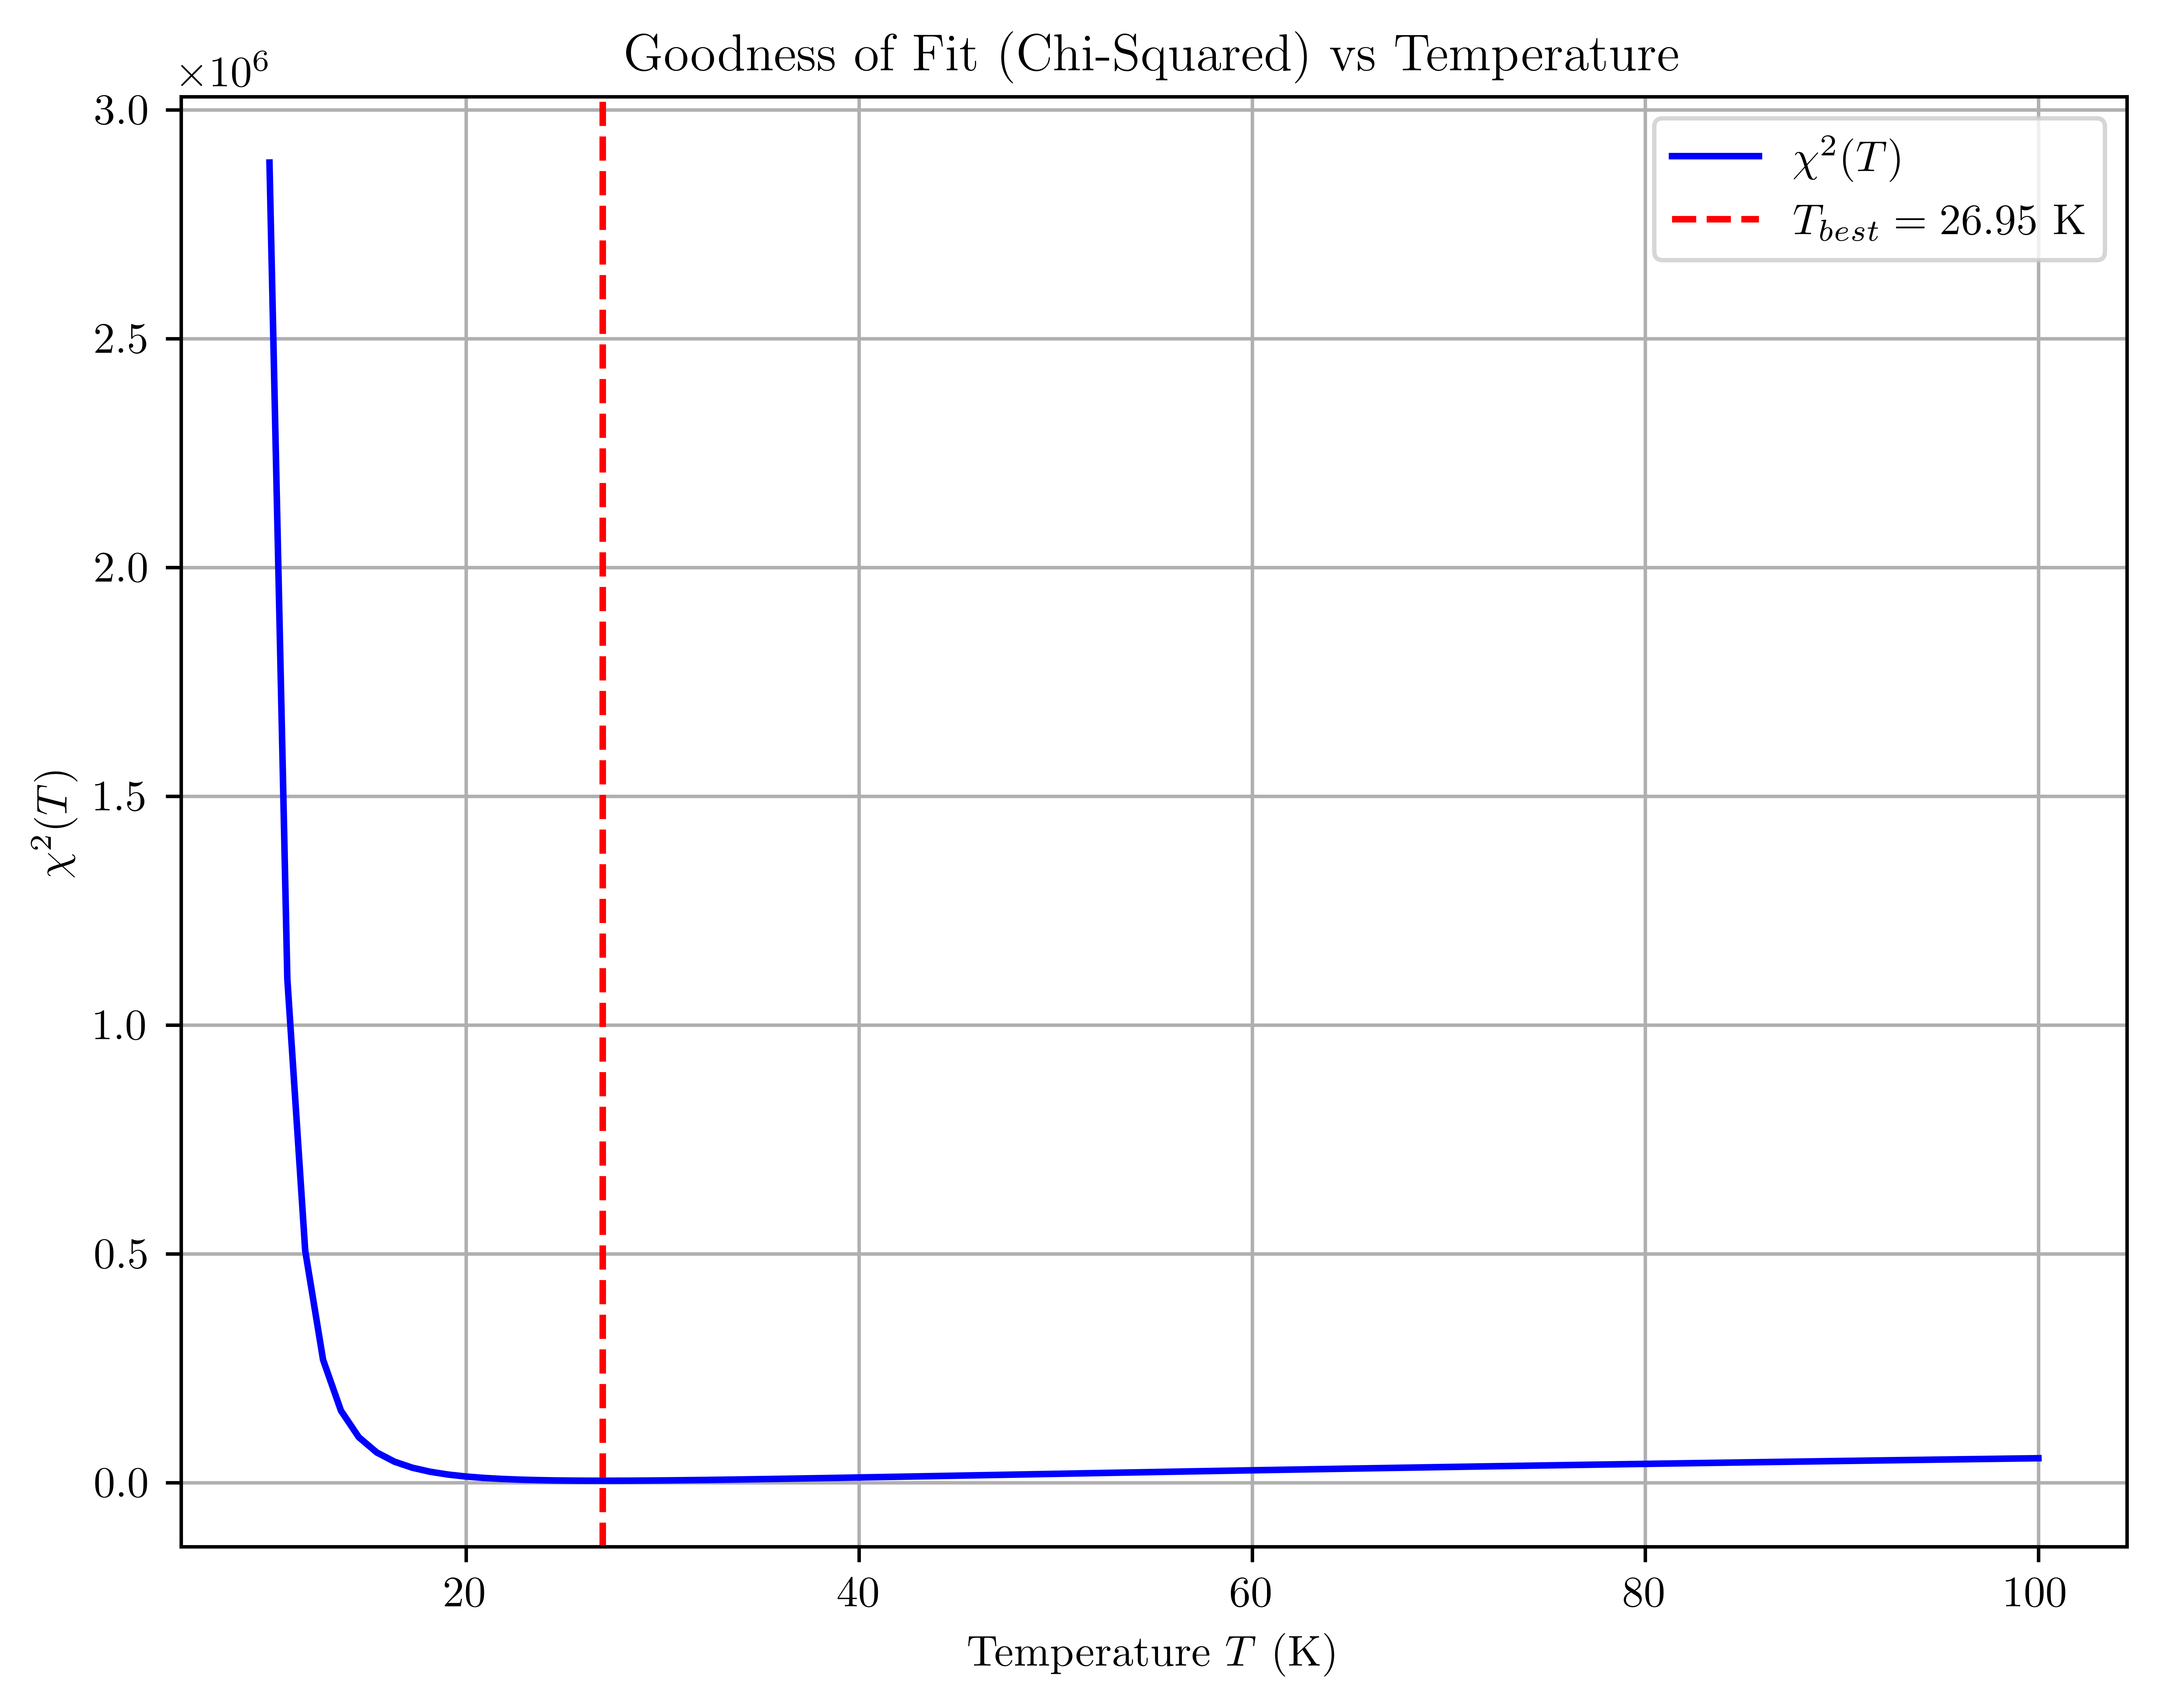

In [143]:
# Function to compute the chi-squared statistic
def compute_chi_squared(observed, expected):
    """
    Computes the chi-squared statistic for observed and expected counts.
    """
    return np.sum((observed - expected) ** 2 / expected)

# Function to compute the goodness of fit (chi-squared) at temperature T
def goodness_of_fit(T, data, bins, k_B):
    """
    Computes the chi-squared statistic as a goodness of fit at a given temperature T.
    """
    beta = 1 / (k_B * T)
    hist, bin_edges = np.histogram(data, bins=bins, range=(0, np.percentile(data, 99.9)), density=False)
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    bin_width = bin_edges[1] - bin_edges[0]
    
    # Compute expected counts
    expected_counts = pdf(bin_centers, beta) * bin_width * len(data)
    
    # Compute chi-squared statistic
    return compute_chi_squared(hist, expected_counts)

N = 100000  # Number of energy samples
bins = 50  # Number of bins for the histogram
T_values = np.linspace(10, 100, 100)  # Wide range of temperatures in Kelvin

# Generate energy samples at a reference temperature
T_ref = 30  # Reference temperature in Kelvin
beta_ref = 1 / (k_B * T_ref)
energy_samples = sample_energy_inverse_transform(N, beta_ref)

# Compute chi-squared values for a range of temperatures
chi_squared_values = [goodness_of_fit(T, energy_samples, bins, k_B) for T in T_values]

# Find T_best (least squares estimate of T) by minimizing chi-squared
result = minimize(lambda T: goodness_of_fit(T[0], energy_samples, bins, k_B), x0=[T_ref], bounds=[(10, 100)])
T_best = result.x[0]
print(f"Least Squares Estimate of T (T_best): {T_best:.5f} K")

# Compute variance of T_best using second derivative of chi-squared
def numerical_second_derivative(f, x, dx=1e-5):
    """Compute the second numerical derivative of a function f at x."""
    return (f(x + dx) - 2 * f(x) + f(x - dx)) / dx**2

chi_squared_func = lambda T: goodness_of_fit(T, energy_samples, bins, k_B)
second_derivative_at_T_best = numerical_second_derivative(chi_squared_func, T_best)
variance_T_best = 1 / second_derivative_at_T_best if second_derivative_at_T_best > 0 else np.inf
print(f"Variance of T_best: {variance_T_best:.5f} K^2")

# Plot chi-squared vs temperature
plt.figure(figsize=(8, 6), dpi=1000)
plt.plot(T_values, chi_squared_values, label=r"$\chi^2(T)$", color="blue")
plt.axvline(T_best, color="red", linestyle="--", label=f"$T_{{best}} = {T_best:.2f}$ K")
plt.xlabel(r"Temperature $T$ (K)")
plt.ylabel(r"$\chi^2(T)$")
plt.title("Goodness of Fit (Chi-Squared) vs Temperature")
plt.legend()
plt.grid(True)
plt.show()

In [146]:
# Constants
N = 100000  # Number of energy samples
T_ref = 30  # Reference temperature in Kelvin

# Generate energy samples using the Inverse Transform Method

beta_ref = 1 / (k_B * T_ref)
energy_samples = sample_energy_inverse_transform(N, beta_ref)

# Compute the sample mean of the energy
mean_energy = np.mean(energy_samples)

# Estimate T from the sample mean
T_estimated = (2 * mean_energy) / k_B
print(f"Estimated Temperature (T): {T_estimated:.5f} K")

variance_energy = np.var(energy_samples)  

# Compute the variance of T
variance_T = (4 * variance_energy) / (k_B**2)
print(f"Variance of Estimated Temperature (T): {variance_T:.5e} K^2")

Estimated Temperature (T): 29.94094 K
Variance of Estimated Temperature (T): 1.80612e+03 K^2


Comparison of Results from Task 4:
            Method   T (K)  Var(T) (K^2)  Relative Deviation (%)
0       Likelihood  29.970  6.906000e-24                0.100000
1  Goodness of Fit  26.949  5.500000e-03               10.170000
2      Sample Mean  29.941  1.810000e+03                0.196667


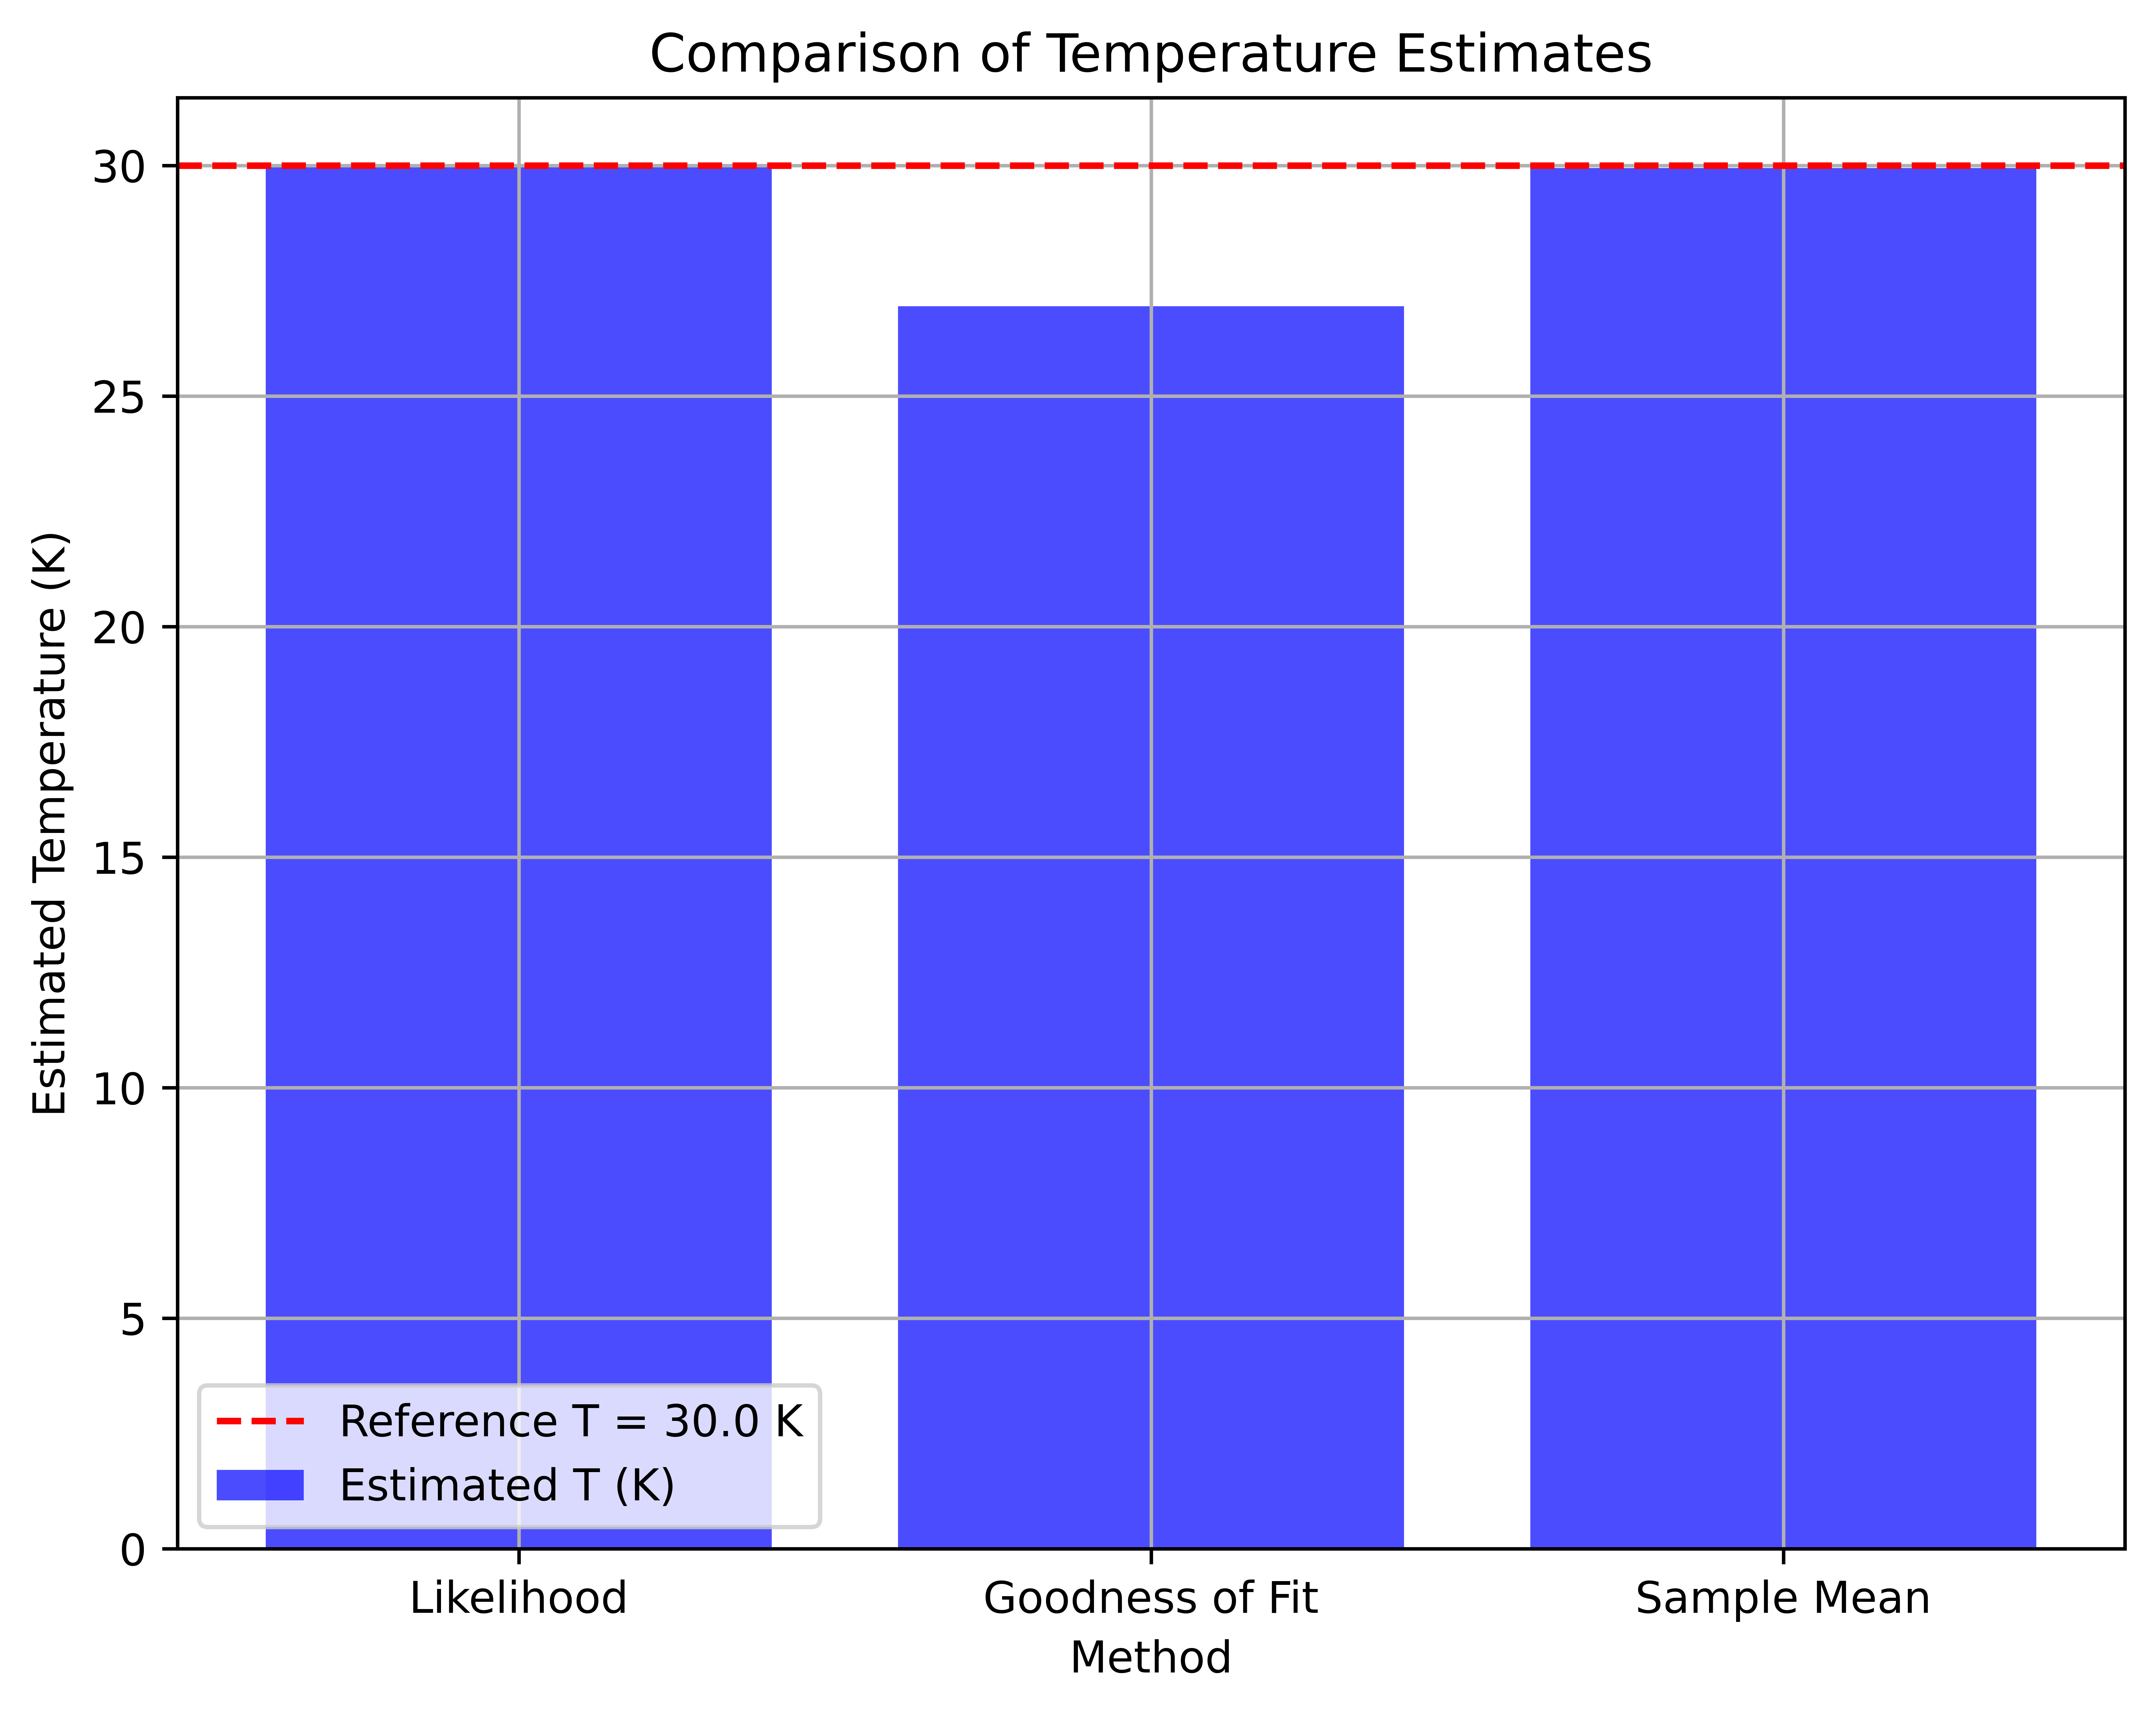

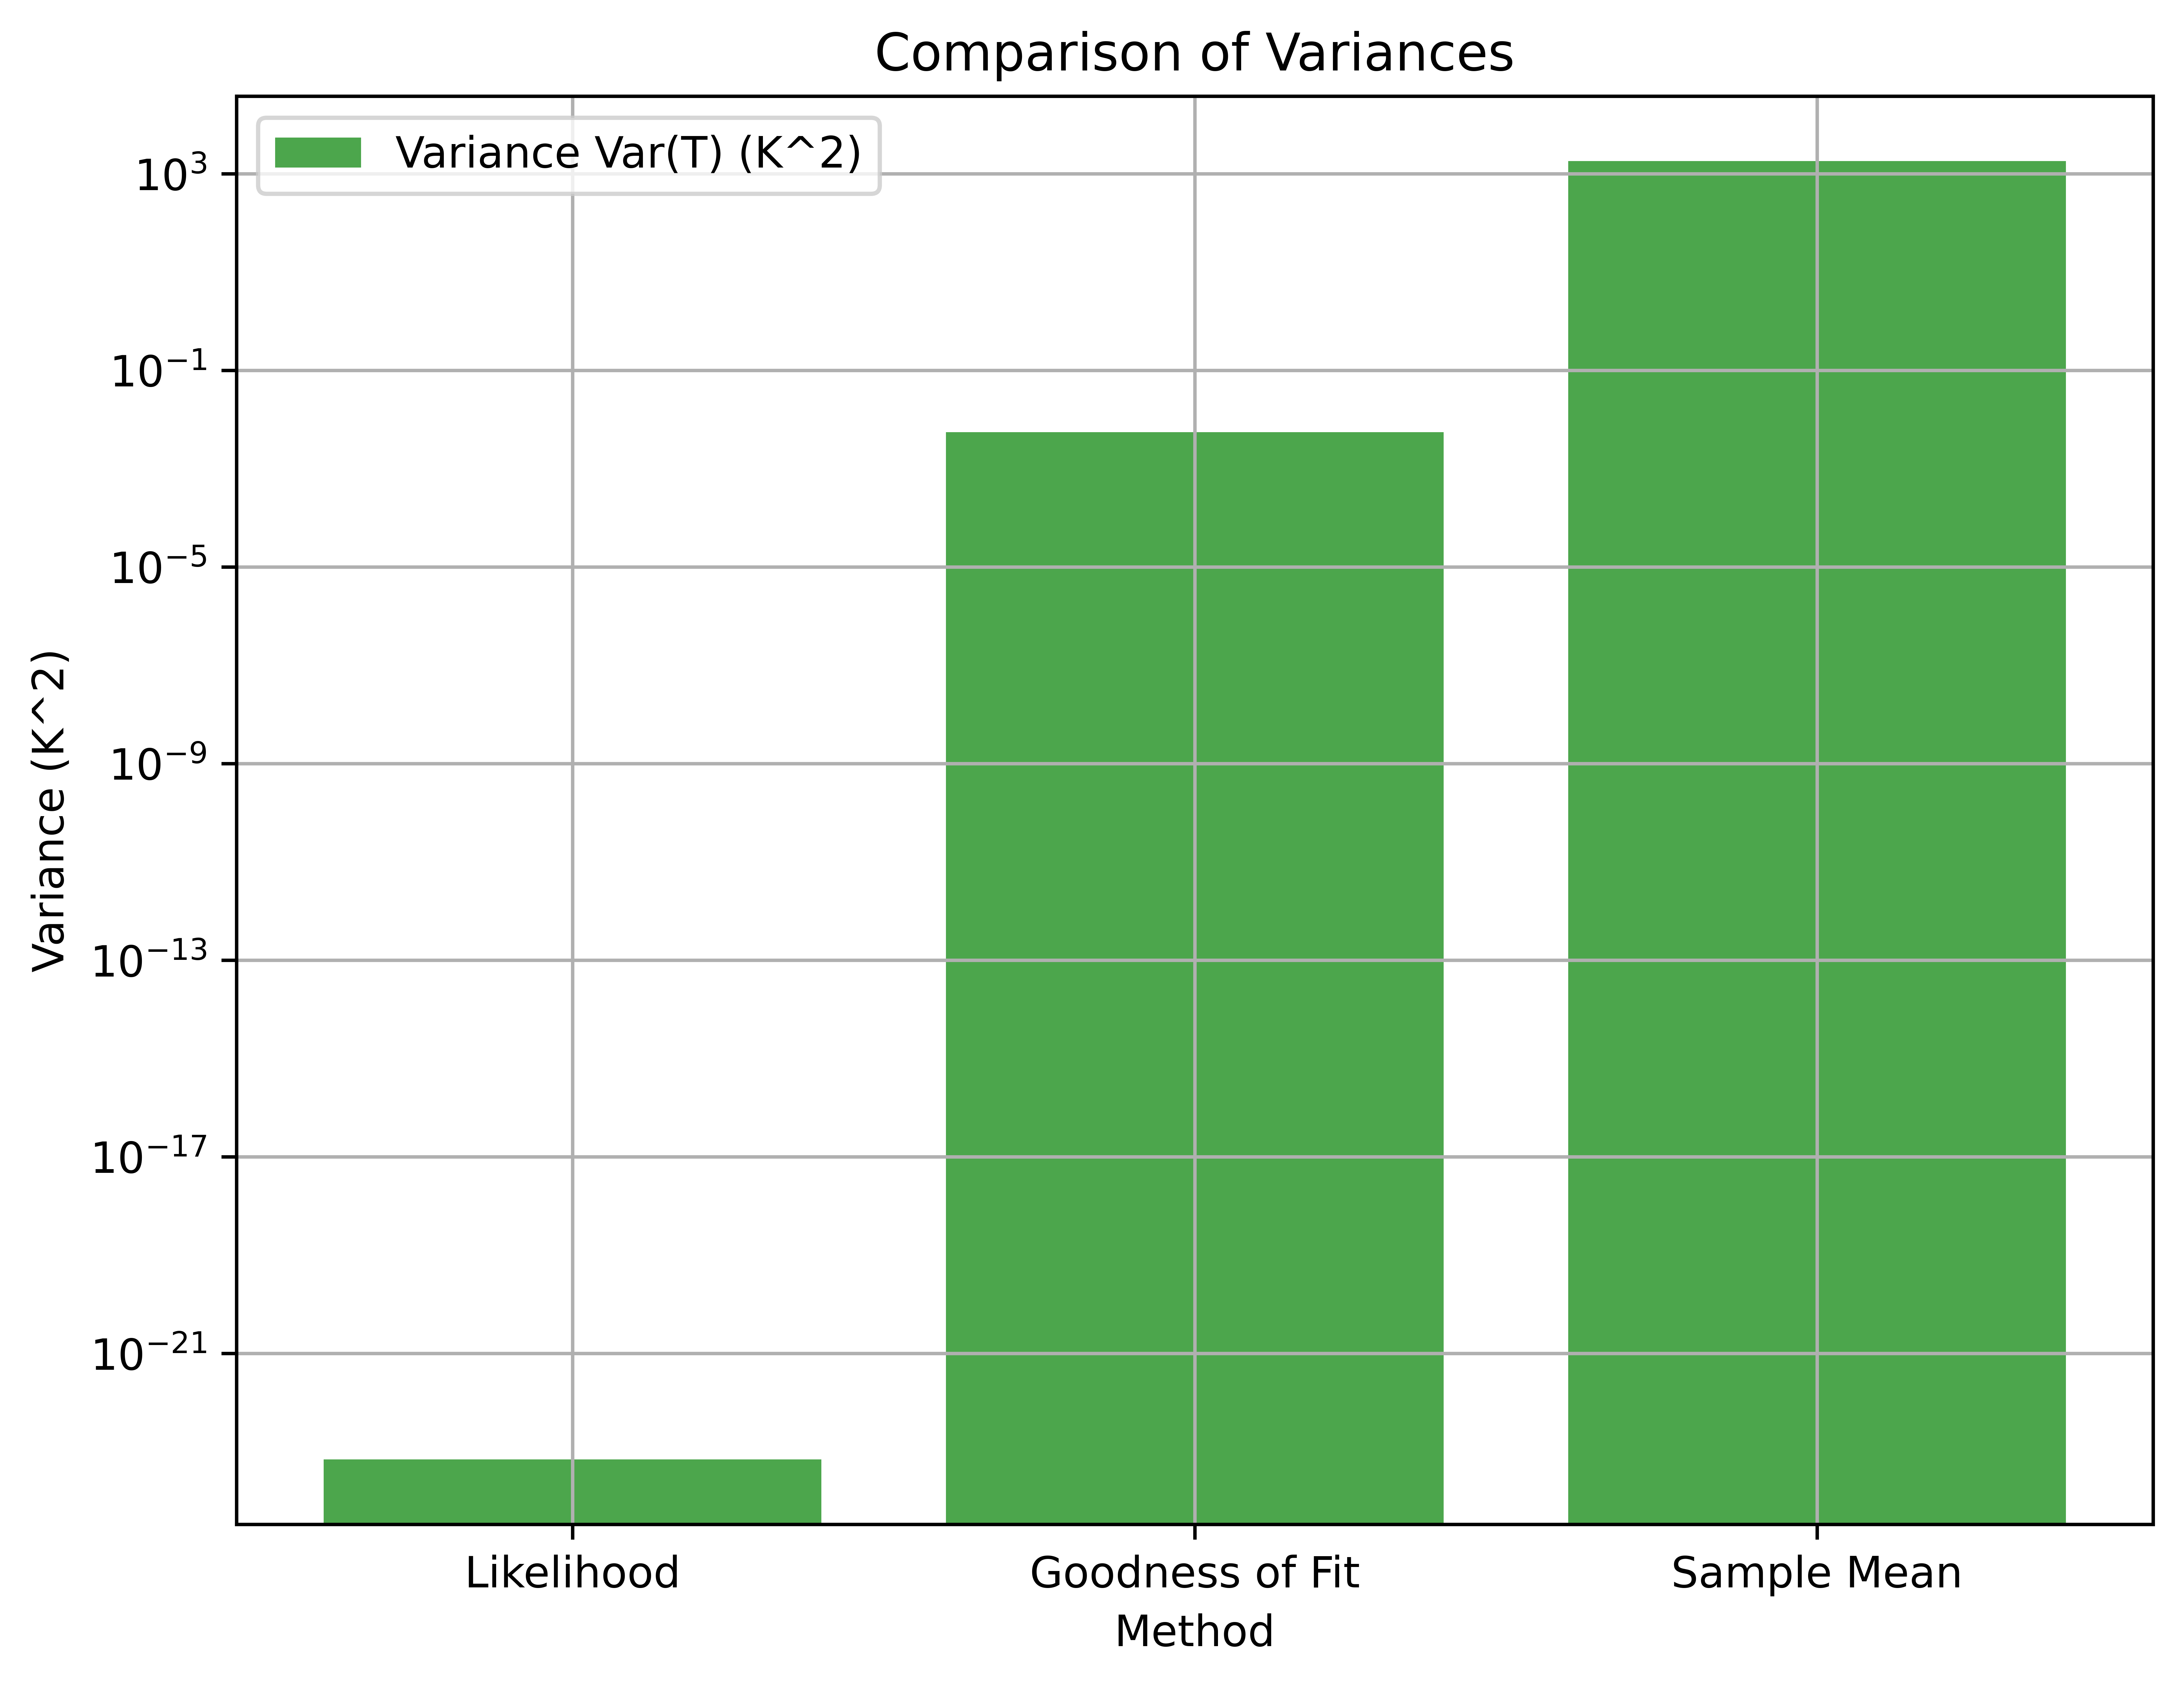

In [3]:



# Data from Task 4 results
methods = ["Likelihood", "Goodness of Fit", "Sample Mean"]
temperatures = [29.97, 26.949, 29.941]  # Temperature estimates in K
variances = [6.906e-24, 5.50e-3, 1.81e3]  # Variances in K^2
T_ref = 30.0  # Reference temperature in K

# Compute relative deviation
relative_deviations = [abs(T - T_ref) / T_ref * 100 for T in temperatures]

# Create a DataFrame for easy display
data = {
    "Method": methods,
    "T (K)": temperatures,
    "Var(T) (K^2)": variances,
    "Relative Deviation (%)": relative_deviations,
}
df = pd.DataFrame(data)

# Display the DataFrame
print("Comparison of Results from Task 4:")
print(df)

# Plotting temperature estimates
plt.figure(figsize=(8, 6), dpi=1000)
plt.bar(methods, temperatures, alpha=0.7, label="Estimated T (K)", color="blue")
plt.axhline(y=T_ref, color="red", linestyle="--", label=f"Reference T = {T_ref} K")
plt.xlabel("Method")
plt.ylabel("Estimated Temperature (K)")
plt.title("Comparison of Temperature Estimates")
plt.legend()
plt.grid(True)
plt.show()

# Plotting variances
plt.figure(figsize=(8, 6), dpi=1000)
plt.bar(methods, variances, alpha=0.7, label="Variance Var(T) (K^2)", color="green")
plt.yscale("log")  # Use logarithmic scale for large range
plt.xlabel("Method")
plt.ylabel("Variance (K^2)")
plt.title("Comparison of Variances")
plt.legend()
plt.grid(True)
plt.show()

Total Pairs Tested: 100
Rejected Pairs (p < 0.05): 6
Accepted Pairs (p >= 0.05): 94


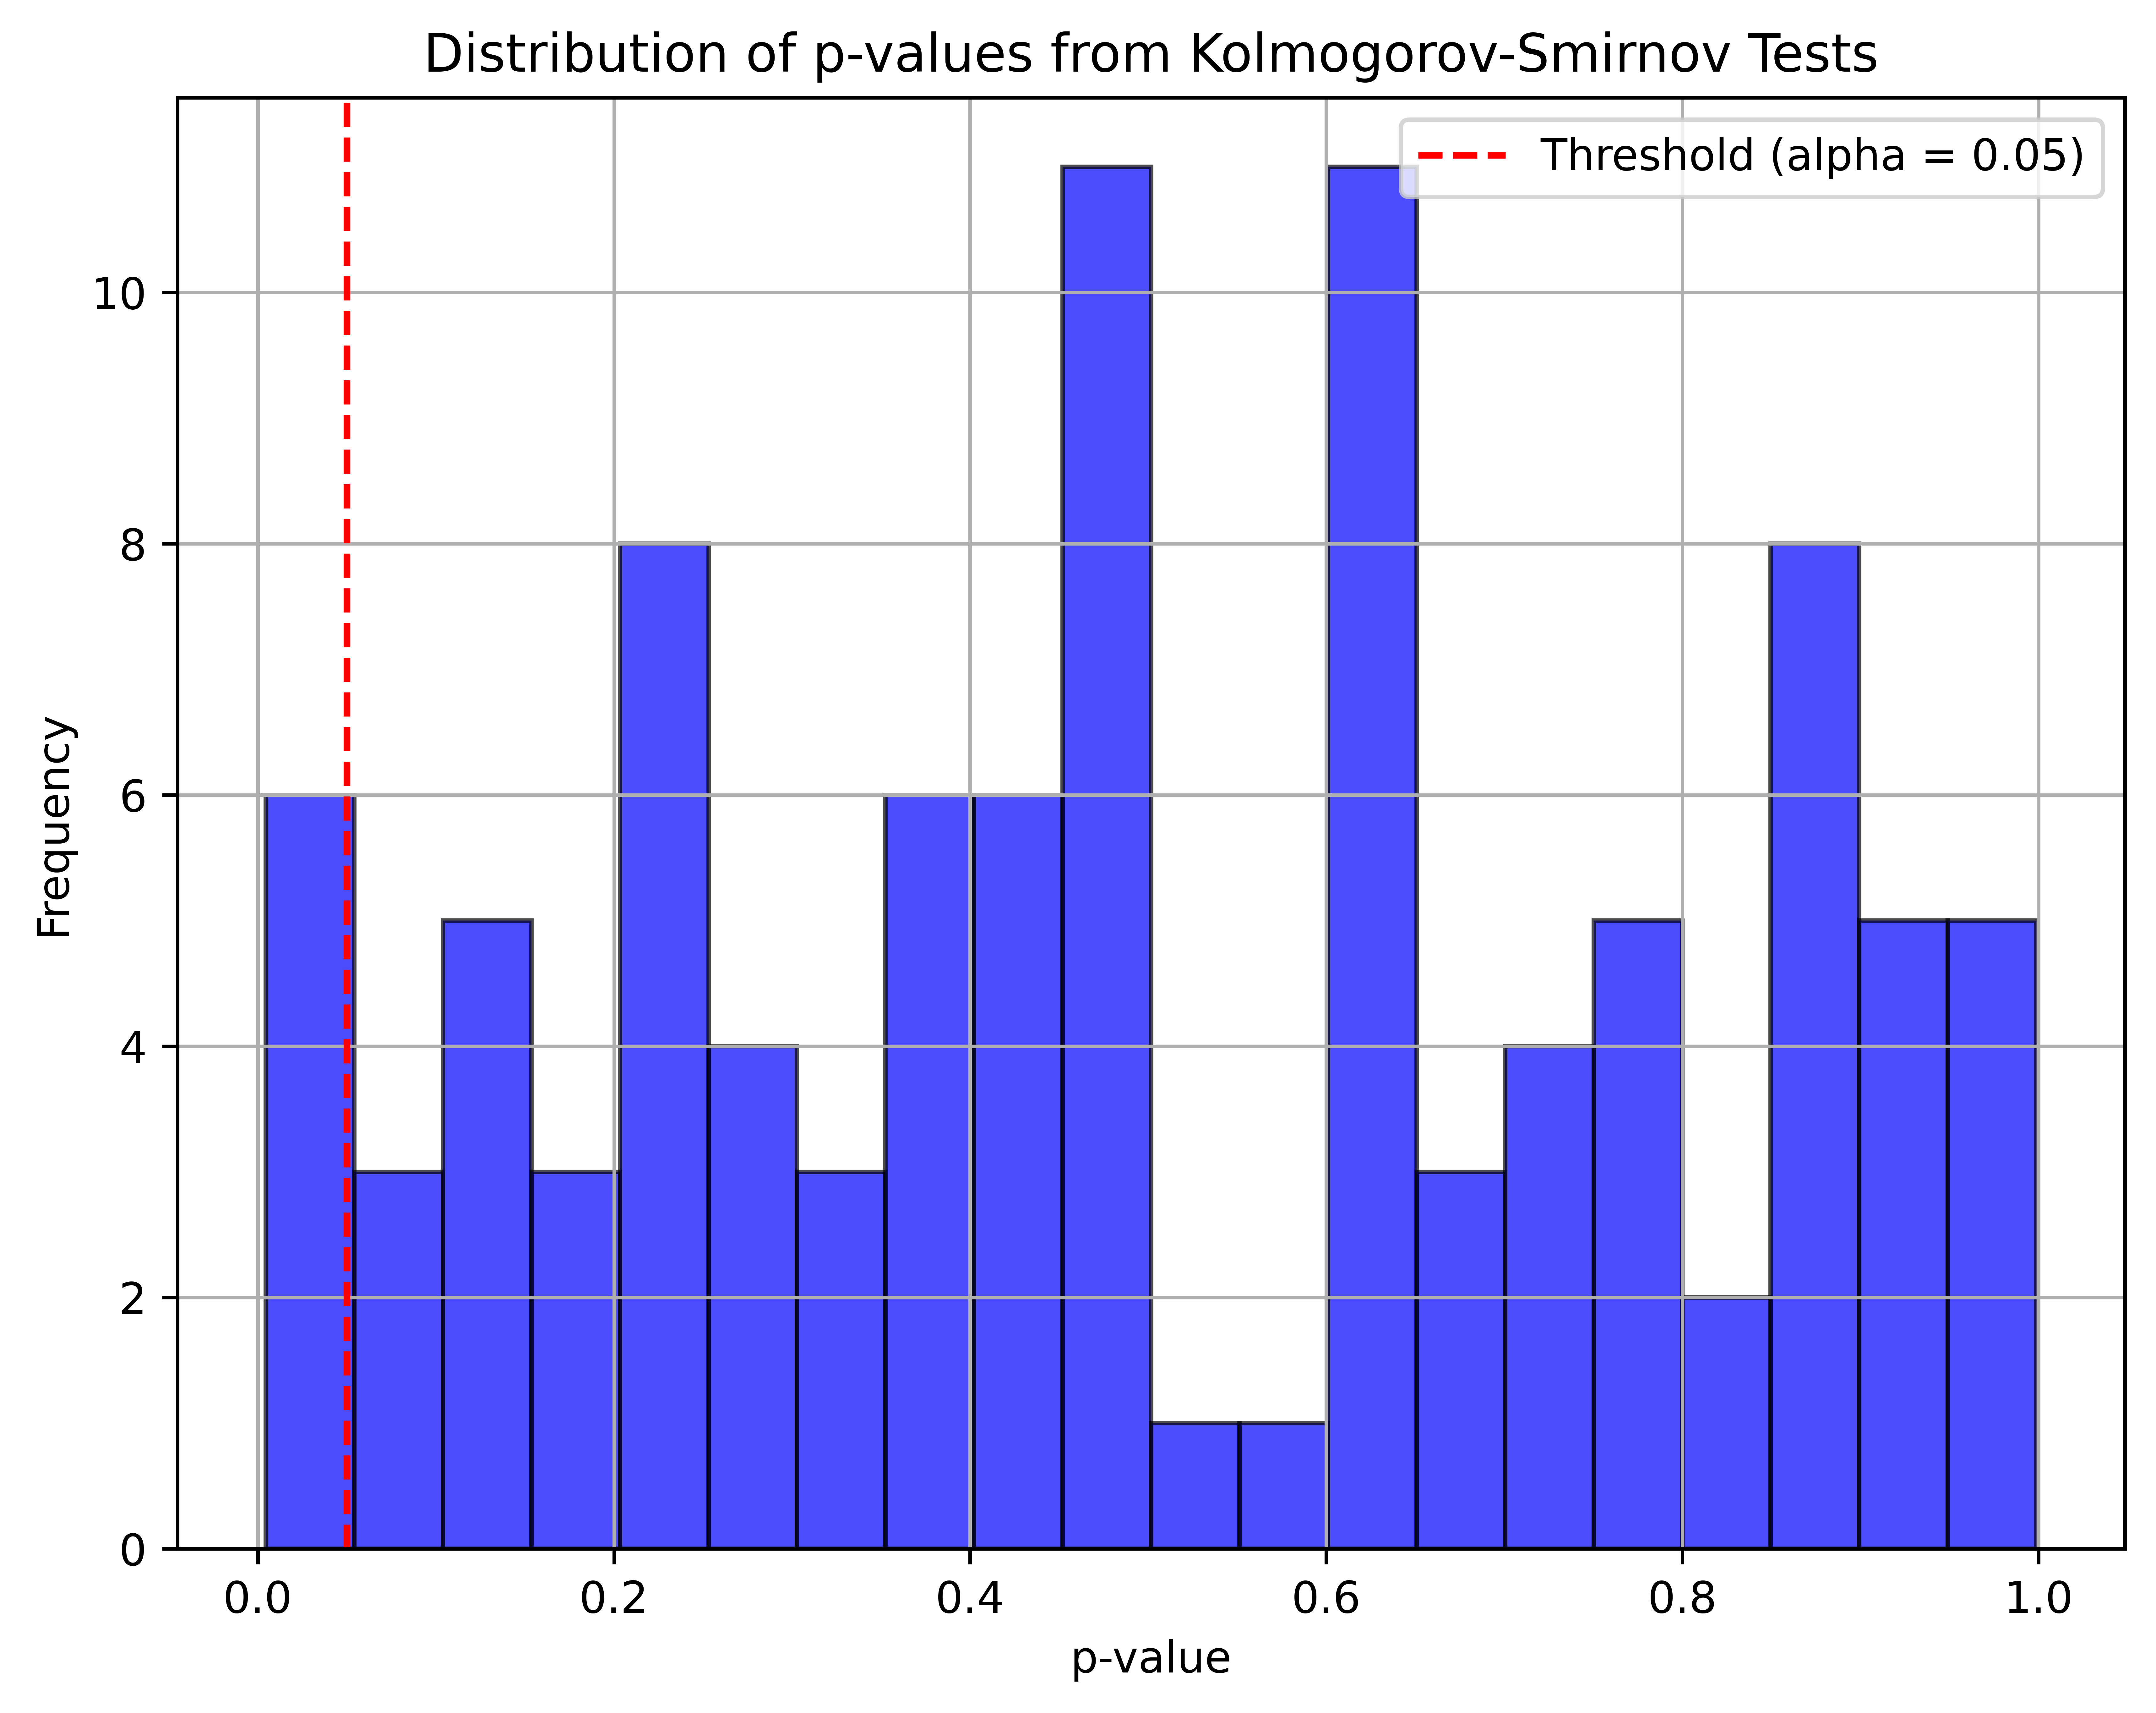

In [20]:
# Parameters
N_exp = 200  # Total number of datasets
N_samples = 1000  # Number of samples per dataset
T = 30  # Reference temperature in Kelvin
beta = 1 / (k_B * T)  # Beta for the reference temperature
alpha = 0.05  # Significance level for hypothesis testing

# Step 1: Generate 200 datasets
datasets = [sample_energy_inverse_transform(N_samples, beta) for _ in range(N_exp)]

# Step 2: Pair the datasets (100 pairs)
pairs = [(datasets[2*i], datasets[2*i+1]) for i in range(N_exp // 2)]

# Step 3: Perform KS tests for each pair
results = []
for i, (data1, data2) in enumerate(pairs):
    ks_stat, p_value = ks_2samp(data1, data2)
    results.append((ks_stat, p_value))

# Step 4: Analyze results with the threshold
rejected_pairs = sum(1 for _, p_value in results if p_value < alpha)
accepted_pairs = len(results) - rejected_pairs

print(f"Total Pairs Tested: {len(results)}")
print(f"Rejected Pairs (p < {alpha}): {rejected_pairs}")
print(f"Accepted Pairs (p >= {alpha}): {accepted_pairs}")

# Plot the p-value distribution
p_values = [p_value for _, p_value in results]
plt.figure(figsize=(8, 6), dpi=1000)
plt.hist(p_values, bins=20, alpha=0.7, color="blue", edgecolor="black")
plt.axvline(alpha, color="red", linestyle="--", label=f"Threshold (alpha = {alpha})")
plt.xlabel("p-value")
plt.ylabel("Frequency")
plt.title("Distribution of p-values from Kolmogorov-Smirnov Tests")
plt.legend()
plt.grid(True)
plt.show()

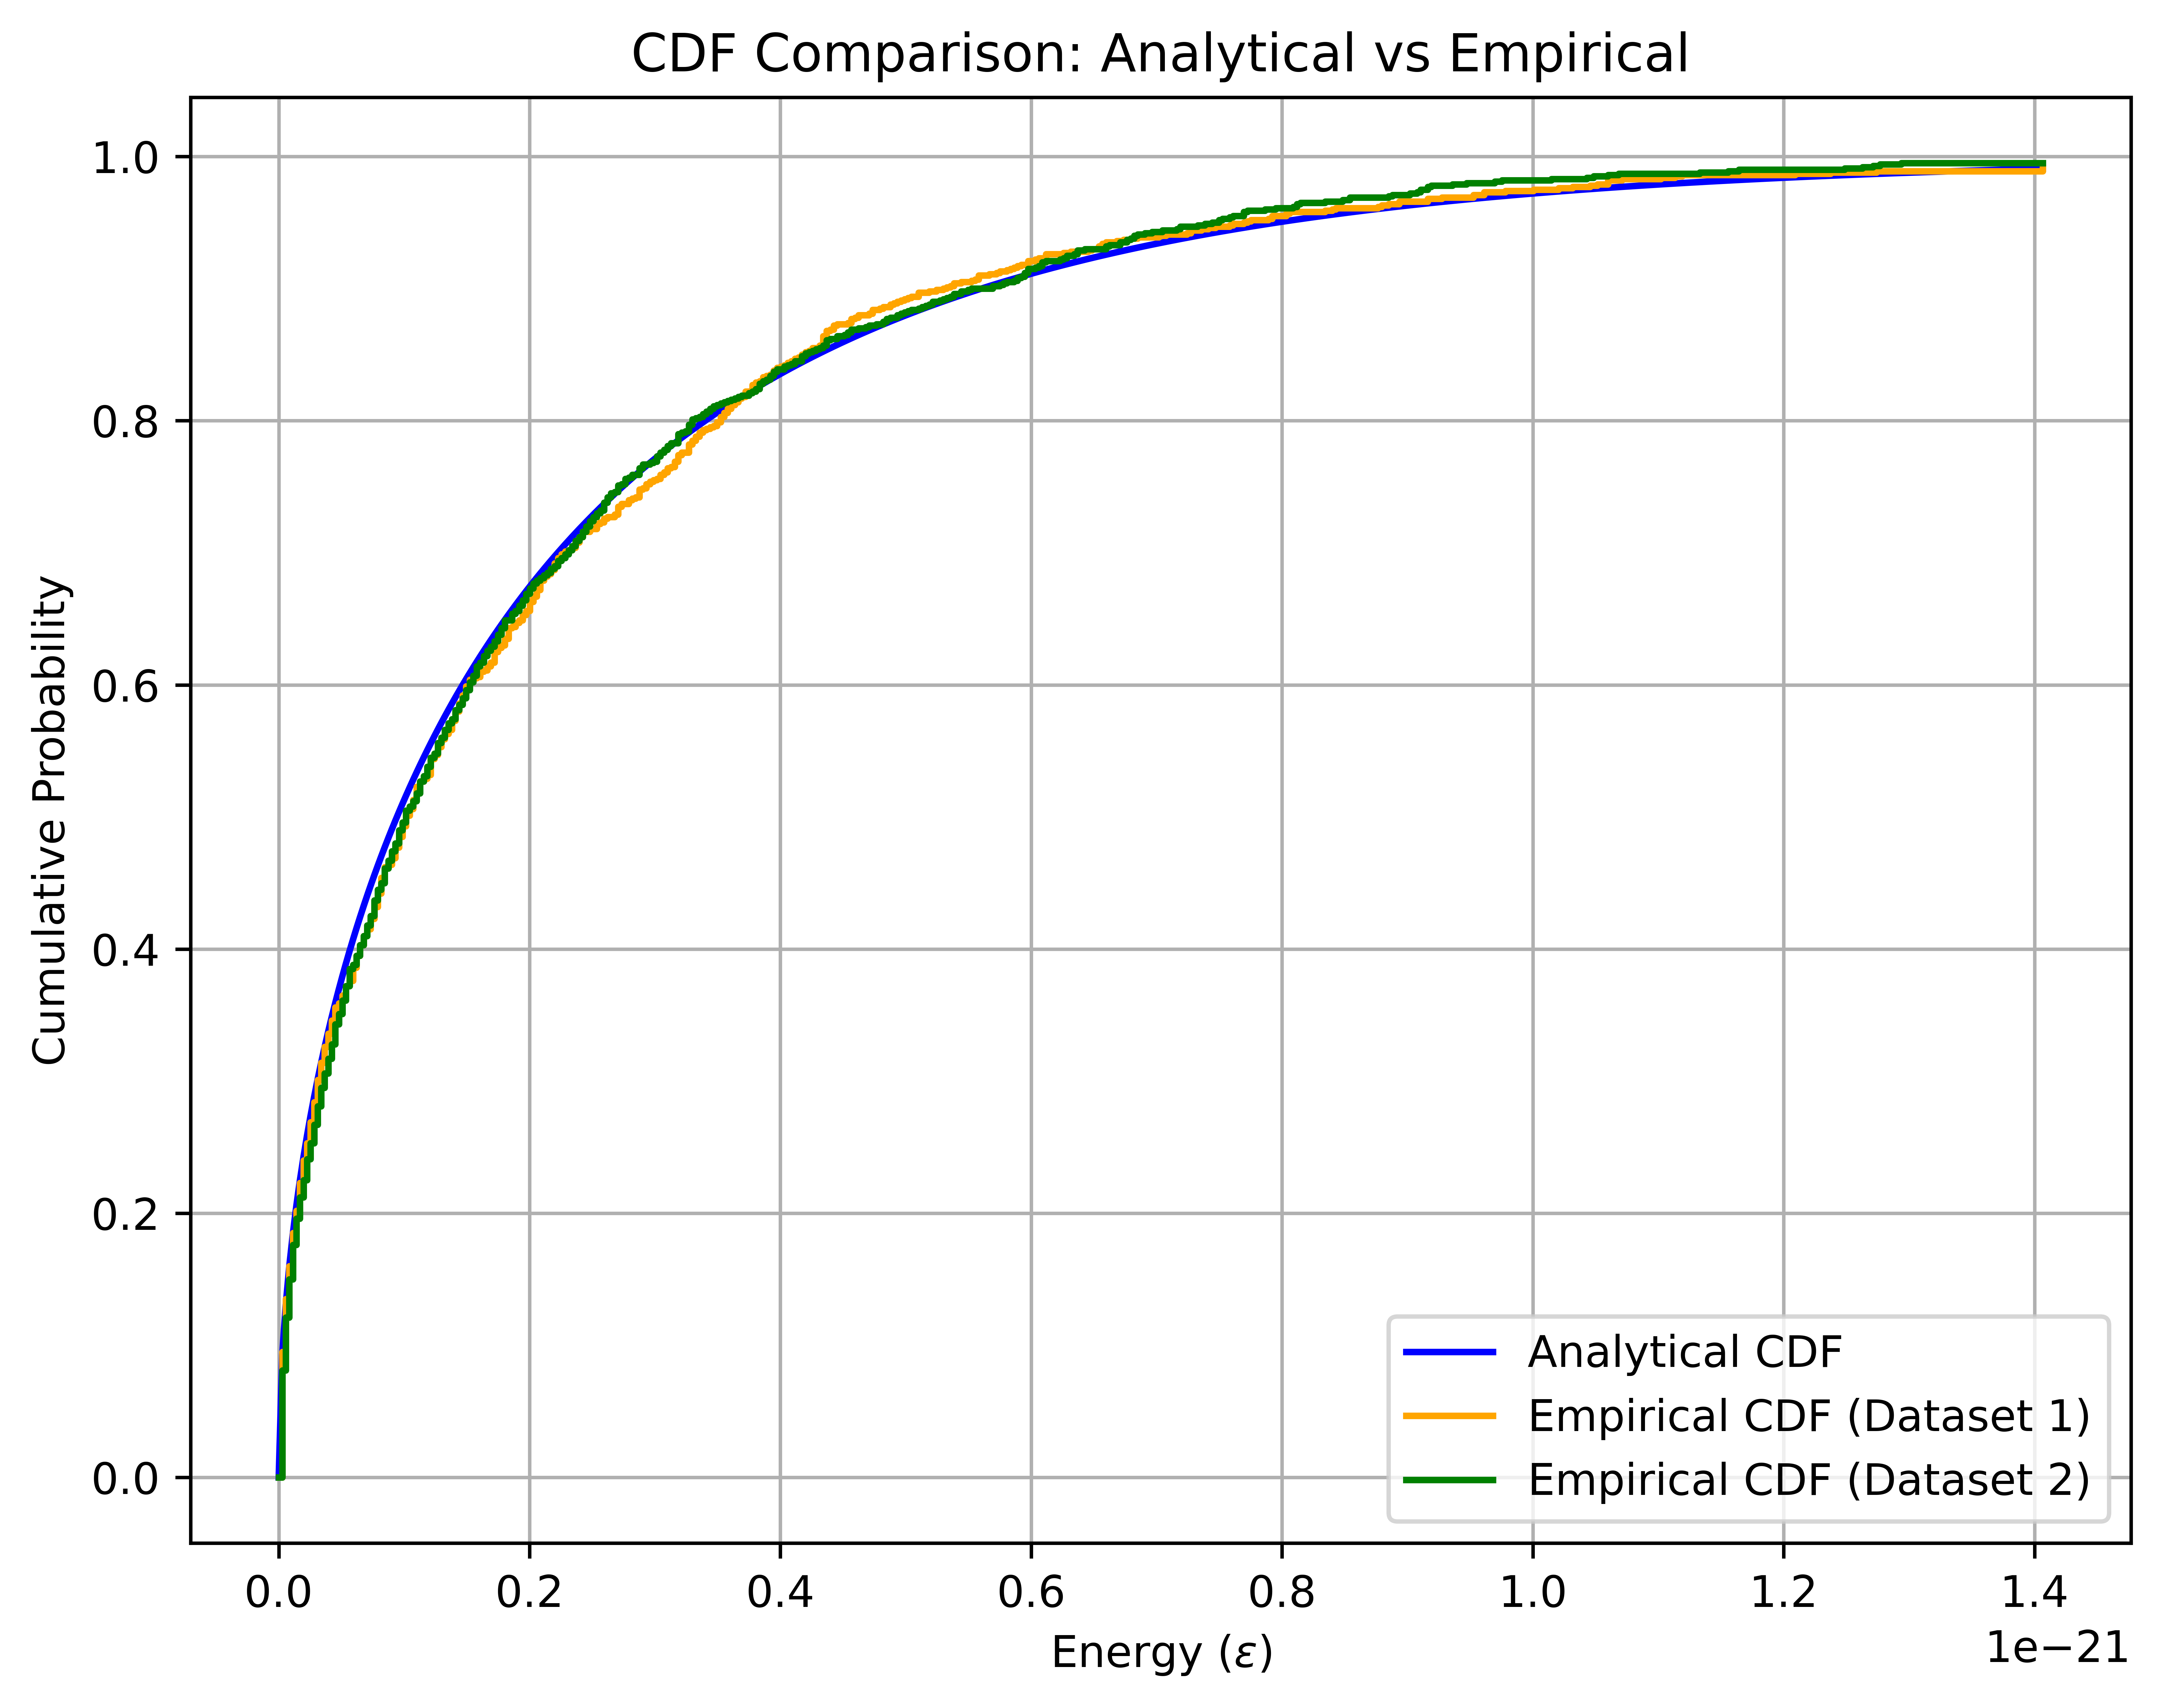

In [13]:


# Function to compute the analytical CDF
def analytical_cdf(eps, beta):
    """Analytical CDF for the energy distribution."""
    return erf(np.sqrt(beta * eps))

# Function to compute the empirical CDF
def empirical_cdf(data, x_values):
    """Compute the empirical CDF for a dataset."""
    cdf = np.array([np.sum(data <= x) / len(data) for x in x_values])
    return cdf

T = 30  # Reference temperature in Kelvin
beta = 1 / (k_B * T)
N_samples = 1000  # Number of samples in each dataset

data1 = sample_energy_inverse_transform(N_samples, beta)
data2 = sample_energy_inverse_transform(N_samples, beta)

# Define x-values for plotting CDFs
x_values = np.linspace(0, np.percentile(data1, 99), 500)

# Compute CDFs
empirical_cdf1 = empirical_cdf(data1, x_values)
empirical_cdf2 = empirical_cdf(data2, x_values)
analytical_cdf_values = analytical_cdf(x_values, beta)

# Plot CDFs
plt.figure(figsize=(8, 6), dpi=1000)
plt.plot(x_values, analytical_cdf_values, label="Analytical CDF", color="blue")
plt.step(x_values, empirical_cdf1, label="Empirical CDF (Dataset 1)", color="orange", where="post")
plt.step(x_values, empirical_cdf2, label="Empirical CDF (Dataset 2)", color="green", where="post")
plt.xlabel("Energy ($\epsilon$)")
plt.ylabel("Cumulative Probability")
plt.title("CDF Comparison: Analytical vs Empirical")
plt.legend()
plt.grid(True)
plt.show()

/Users/gabriel/Code/Stats Project/myenv/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:156: RuntimeWarning: floating point number truncated to an integer
  return scu._smirnovci(n, q)


Total Pairs Tested: 100
Rejected Pairs (KS statistic > Critical Distance): 100
Accepted Pairs (KS statistic <= Critical Distance): 0


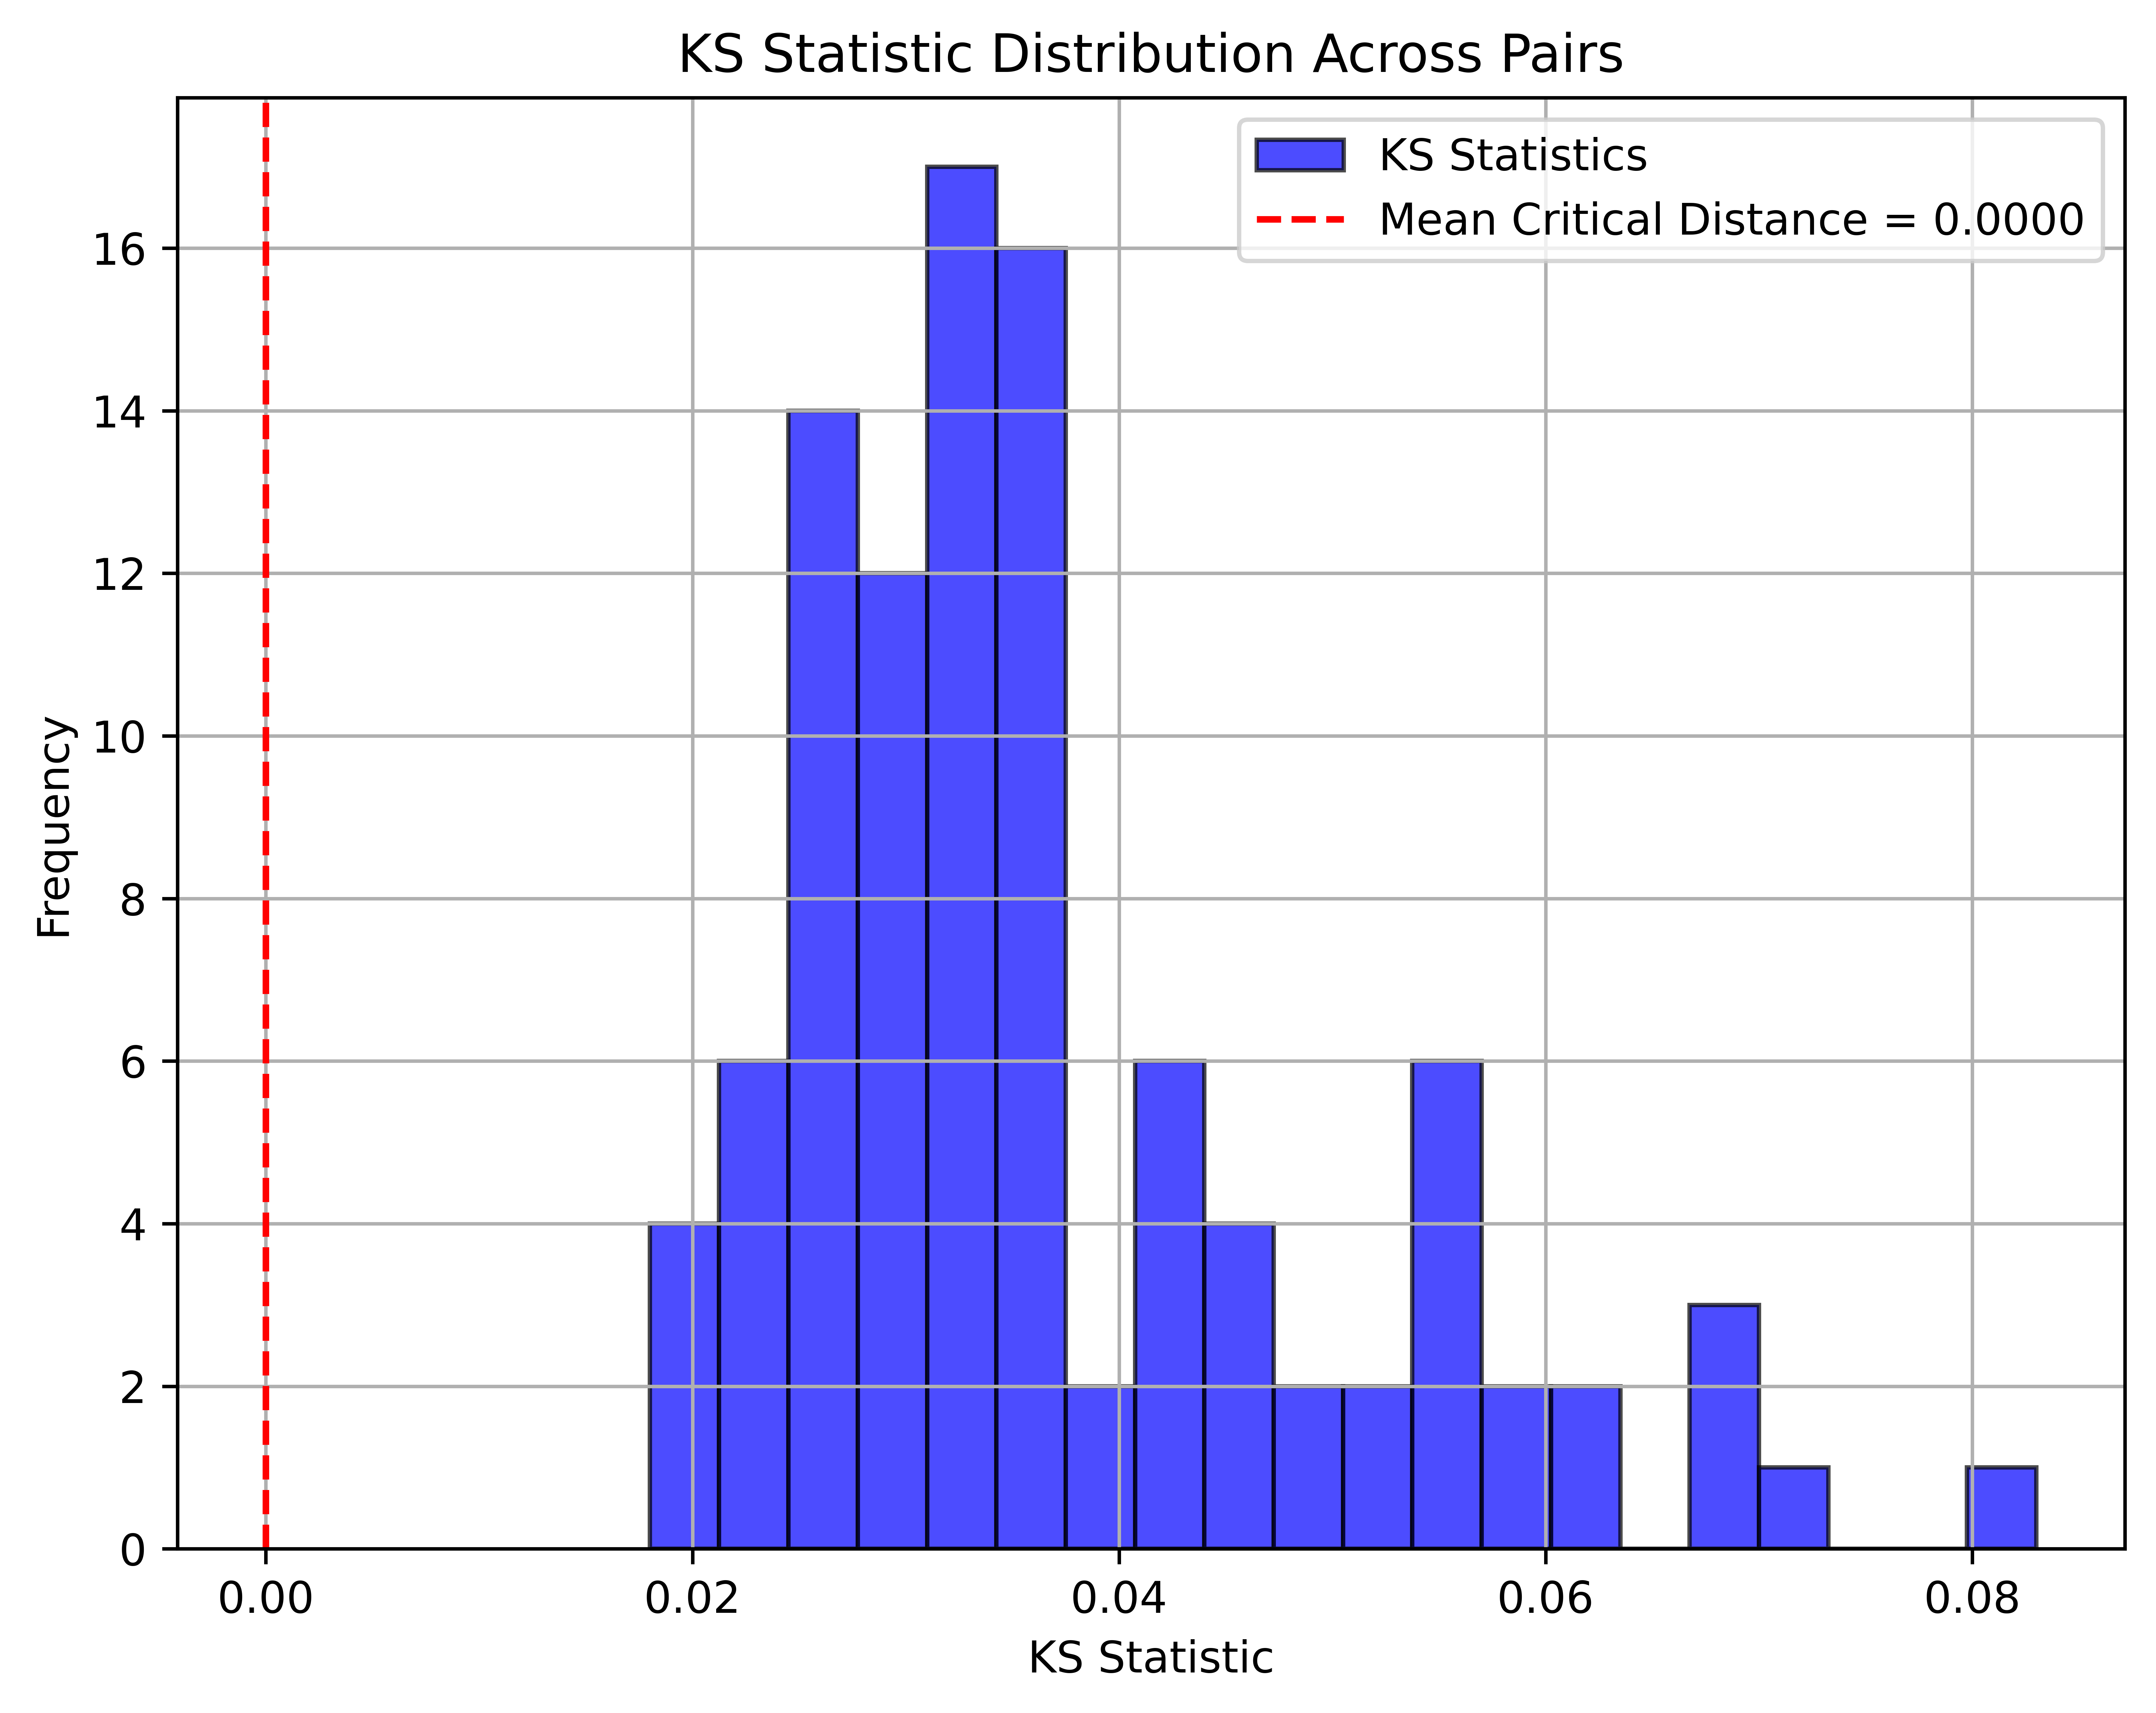

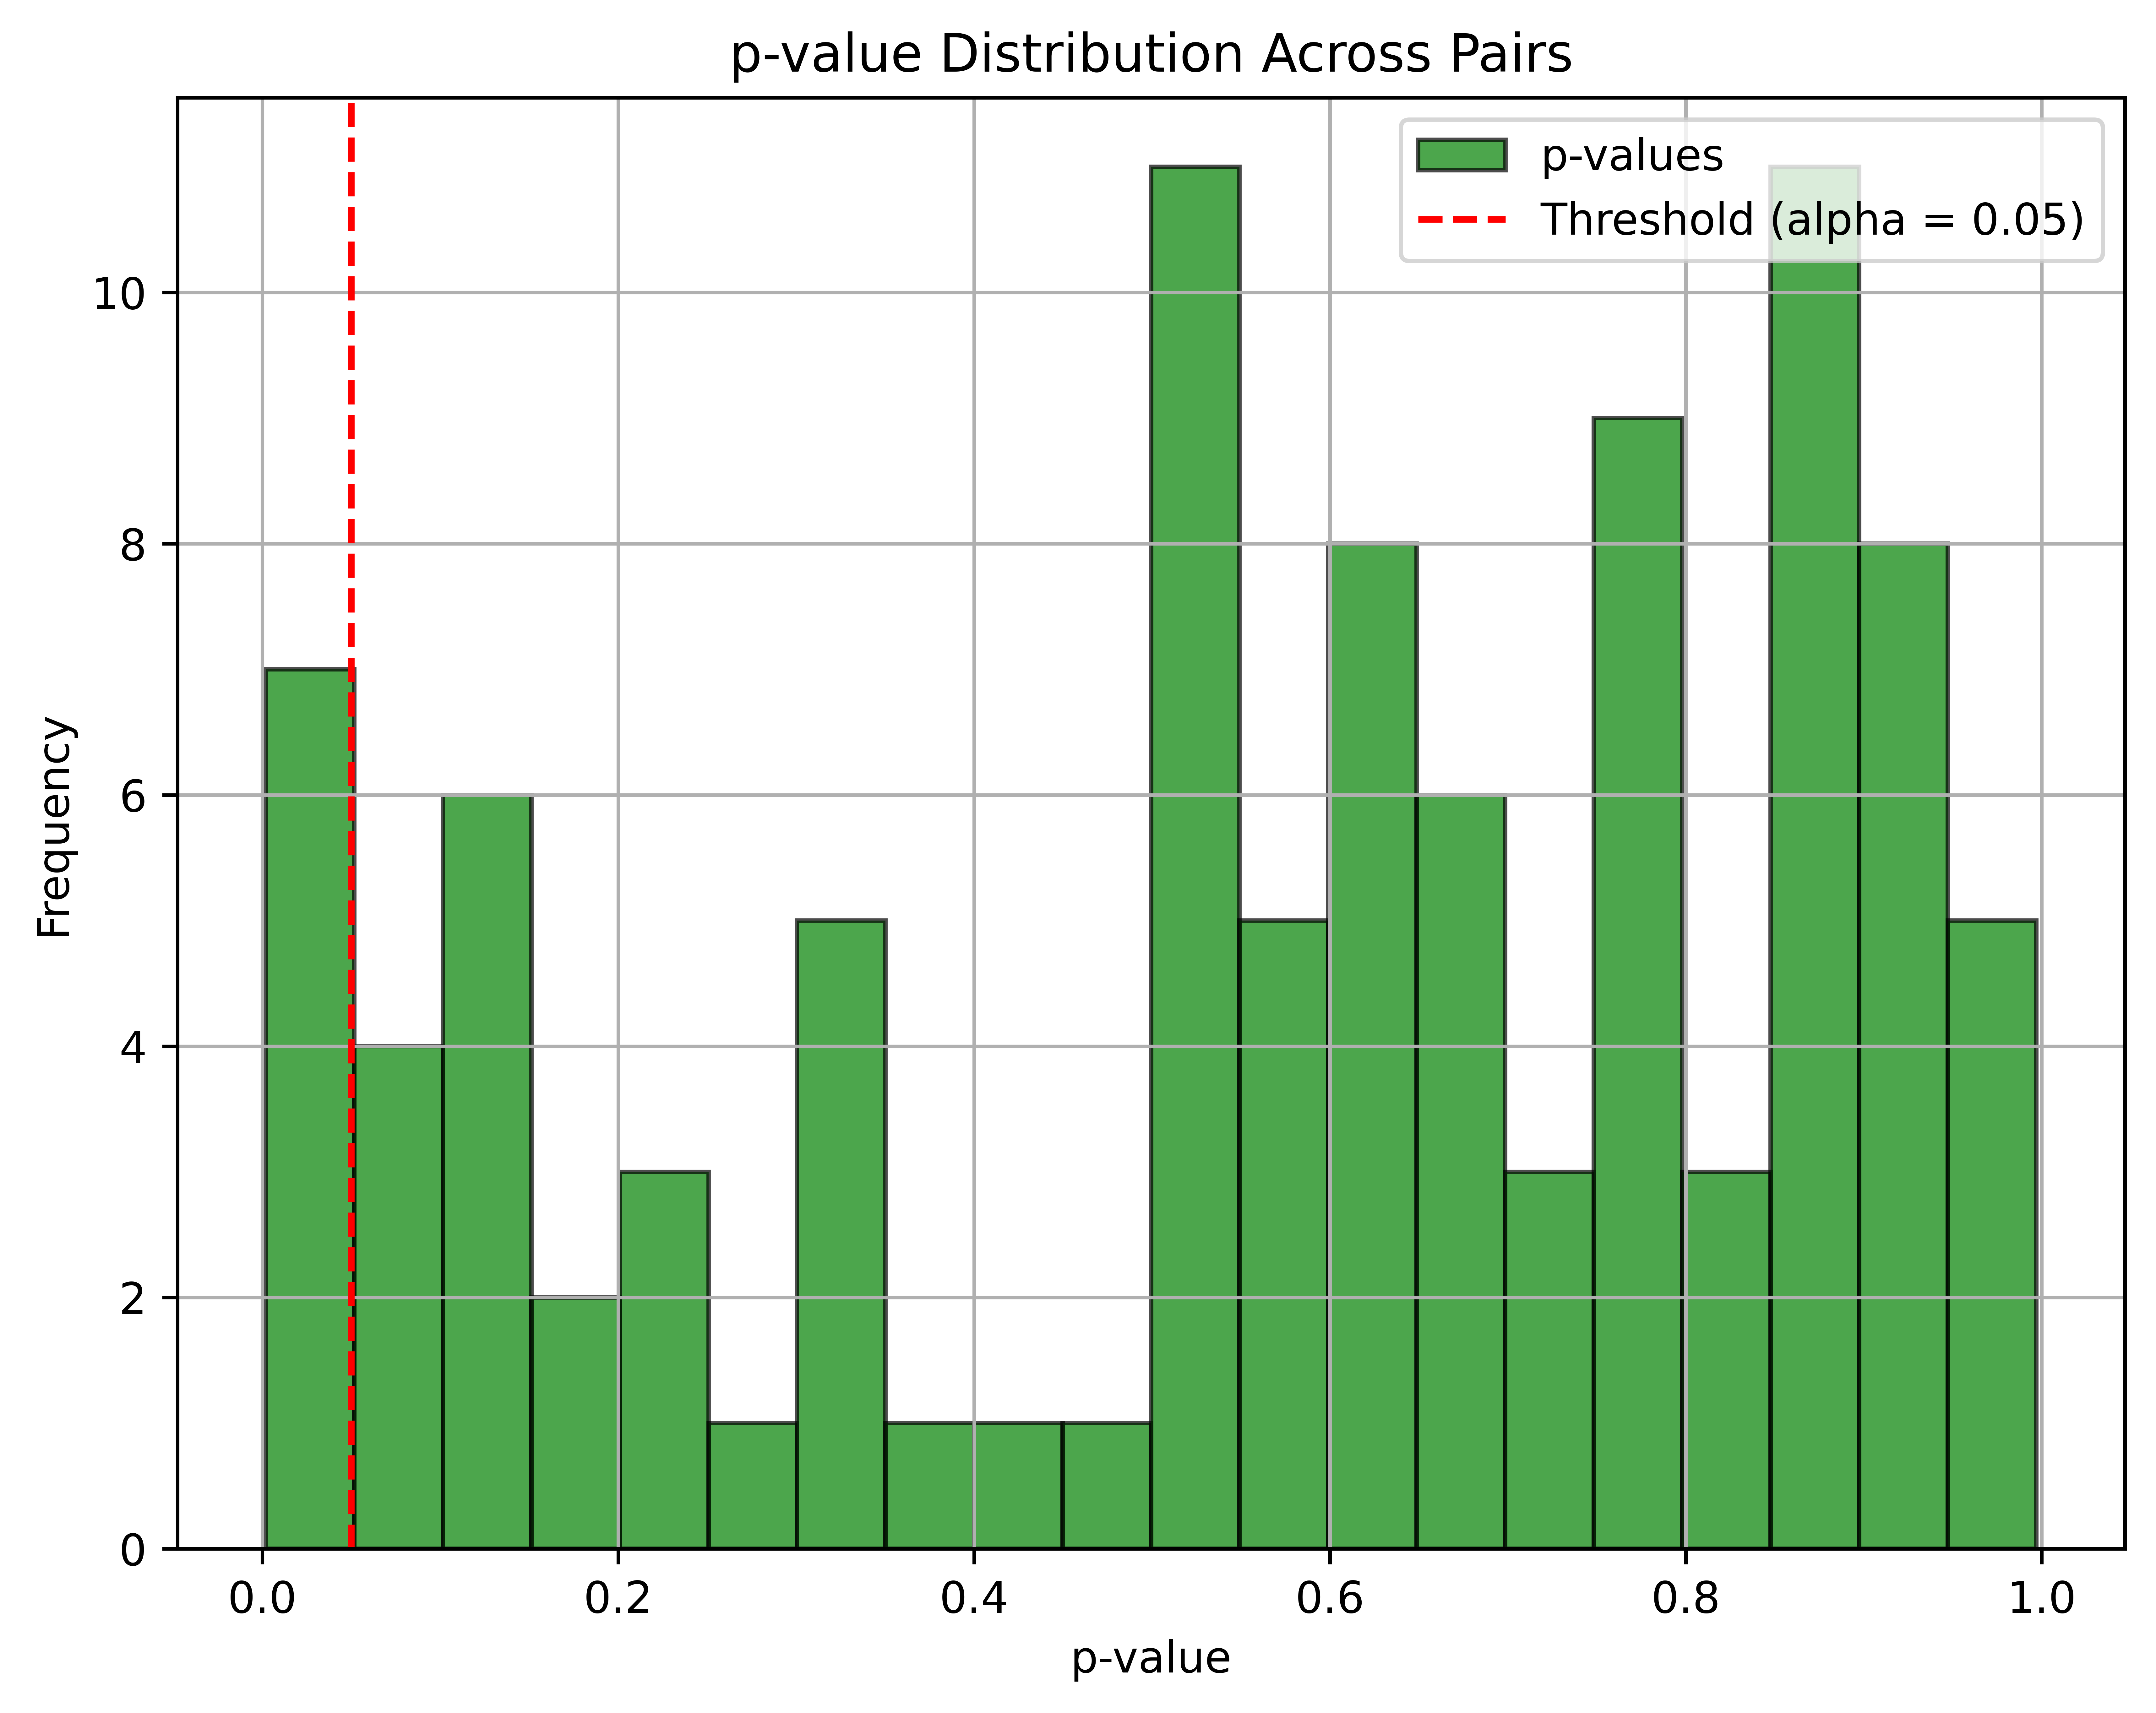

In [10]:

# Parameters
N_exp = 200  # Total number of datasets
N_samples = 1000  # Number of samples per dataset
T = 30  # Reference temperature in Kelvin
beta = 1 / (k_B * T)  # Beta for the reference temperature
alpha = 0.05  # Significance level for hypothesis testing

# Function to calculate c(alpha)
def calculate_c_alpha(alpha):
    """Calculate the critical constant c(alpha) for the KS test at a given significance level alpha."""
    return ksone.ppf(1 - alpha / 2, float('inf'))  # Approximation for large N

# Step 1: Generate 200 datasets
datasets = [sample_energy_inverse_transform(N_samples, beta) for _ in range(N_exp)]

# Step 2: Pair the datasets (100 pairs)
pairs = [(datasets[2 * i], datasets[2 * i + 1]) for i in range(N_exp // 2)]

# Step 3: Perform KS tests for each pair
results = []
critical_distance = []
c_alpha = calculate_c_alpha(alpha)  # Calculate c(alpha) for the given alpha

for i, (data1, data2) in enumerate(pairs):
    # Compute the KS statistic (maximum separation)
    ks_stat, p_value = ks_2samp(data1, data2)
    results.append((ks_stat, p_value))

    # Calculate the critical distance
    D_crit = c_alpha * np.sqrt((N_samples + N_samples) / (N_samples * N_samples))
    critical_distance.append(D_crit)

# Step 4: Compare KS statistic with critical distance
rejected_pairs = []
accepted_pairs = []

for i, (ks_stat, p_value) in enumerate(results):
    if ks_stat > critical_distance[i]:
        rejected_pairs.append(i)
    else:
        accepted_pairs.append(i)

# Step 5: Display results
print(f"Total Pairs Tested: {len(pairs)}")
print(f"Rejected Pairs (KS statistic > Critical Distance): {len(rejected_pairs)}")
print(f"Accepted Pairs (KS statistic <= Critical Distance): {len(accepted_pairs)}")

# Plot results for visualization
ks_stats = [r[0] for r in results]
p_values = [r[1] for r in results]

import matplotlib.pyplot as plt

# Plot histogram of KS statistics
plt.figure(figsize=(8, 6), dpi=1000)
plt.hist(ks_stats, bins=20, alpha=0.7, color="blue", edgecolor="black", label="KS Statistics")
plt.axvline(np.mean(critical_distance), color="red", linestyle="--", label=f"Mean Critical Distance = {np.mean(critical_distance):.4f}")
plt.xlabel("KS Statistic")
plt.ylabel("Frequency")
plt.title("KS Statistic Distribution Across Pairs")
plt.legend()
plt.grid(True)
plt.show()

# Plot histogram of p-values
plt.figure(figsize=(8, 6), dpi=1000)
plt.hist(p_values, bins=20, alpha=0.7, color="green", edgecolor="black", label="p-values")
plt.axvline(alpha, color="red", linestyle="--", label=f"Threshold (alpha = {alpha})")
plt.xlabel("p-value")
plt.ylabel("Frequency")
plt.title("p-value Distribution Across Pairs")
plt.legend()
plt.grid(True)
plt.show()